In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm
import vector
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict
import seaborn as sns

import tensorflow as tf
import tensorflow.saved_model
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Add, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model, model_from_json, load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from lbn import LBN, LBNLayer

In [2]:
train = True

In [3]:
tag_ = "LBNResNet_Higgs_custom_2024v2"
tagdir = os.path.join(os.getcwd(), tag_)
if not os.path.exists(tagdir):
    os.mkdir(tagdir)
else:
    print(f"{tag_} exists")

LBNResNet_Higgs_custom_2024v2 exists


In [4]:
# Load the TensorBoard notebook extension
#%reload_ext tensorboard
#from tensorboard import notebook
#notebook.list() # View open TensorBoard instances
## Control TensorBoard display. If no port is provided, 
## the most recently launched TensorBoard is used
#notebook.display(port=6006, height=1000)

In [5]:
def PlotHistory(history, path=None):
    """ Takes history from Keras training and makes loss plots (batch and epoch) and learning rate plots """
    #----- Figure -----#
    variables = sorted([key for key in history.epochs.keys() if 'val' not in key and 'val_'+key in history.epochs.keys()])
    variables += ["lr"]
    N = len(variables)
    print(f"variables: {variables}")
    fig, ax = plt.subplots(N,2,figsize=(12.5,N*2),sharex='col')
    plt.subplots_adjust(left    = 0.1,
                        right   = 0.6,
                        top     = 0.9,
                        bottom  = 0.1,
                        hspace  = 0.5,
                        wspace  = 0.4)
    
    #----- Batch Plots -----#
    for i,var in enumerate(variables):
        ax[i,0].plot(history.batches['batch'],history.batches[var],'k')
        ax[i,0].set_title(var)
        ax[i,0].set_xlabel('Batch')
        
    #----- Epoch Plots -----#
    for i,var in enumerate(variables):
        ax[i,1].plot(history.epochs['epoch'],history.epochs[var],label='train')
        if 'val_'+var in history.epochs.keys():
            ax[i,1].plot(history.epochs['epoch'],history.epochs['val_'+var],label='validation')
        ax[i,1].set_title(var)
        ax[i,1].legend()
        ax[i,1].set_xlabel('Epoch')

    png_name = 'Loss_Acc_LR.png'
    fig.savefig(os.path.join(path, png_name), dpi=300)
    print('Curves saved as %s'%png_name)
#######################################################


def getp4(df, vars=[], LVtype=""):
    """
        df: The main dfataframe
        vars = [p4 components of obj]
        LVtype = ptetaphim / pxpypze
    """
    for var in vars:
        if var not in list(df.keys()):
            df[var] = 0.0
    p4 = None
    if LVtype == "ptetaphim":
        p4 = vector.array({"pt": df[vars[0]].to_numpy(),
                           "eta": df[vars[1]].to_numpy(),
                           "phi": df[vars[2]].to_numpy(),
                           "M": df[vars[3]].to_numpy()})
    elif LVtype == "pxpypze":
        p4 = vector.array({"px": df[vars[0]].to_numpy(),
                           "py": df[vars[1]].to_numpy(),
                           "pz": df[vars[2]].to_numpy(),
                           "E": df[vars[3]].to_numpy()})
        

    return p4

def setp4(df, vars=[]):
    p4 = getp4(df, vars=vars)
    obj = vars[0].split('_')[0]
    num = vars[0].split('_')[1]
    key = f'{obj}_{num}' if len(vars[0].split('_')) > 2 else f'{obj}'

    df[f'{key}_px'] = p4.px
    df[f'{key}_py'] = p4.py
    df[f'{key}_pz'] = p4.pz
    df[f'{key}_E']  = p4.E

In [6]:
#indf = "df_DY_v5_processed_scaled_metphi.h5"
#indf = "df_DY_v5_processed.h5"
indf = "/Users/gsaha/Work/IPHC/MachineLearning/TauML/Input/GluGluHToTauTauSMdata_11.h5"
df = pd.read_hdf(indf)
#df = df.drop(columns=["total_tau_phi"]) # new
df = df.dropna()
df.head(10)

,pt_tau_1,pt_tau_2,ptCorrPNet_tau_1,ptCorrPNet_tau_2,eta_tau_1,eta_tau_2,phi_tau_1,phi_tau_2,mass_tau_1,mass_tau_2,dxy_tau_1,dxy_tau_2,dz_tau_1,dz_tau_2,rawDeepTau2018v2p5VSe_tau_1,rawDeepTau2018v2p5VSe_tau_2,rawDeepTau2018v2p5VSjet_tau_1,rawDeepTau2018v2p5VSjet_tau_2,rawDeepTau2018v2p5VSmu_tau_1,rawDeepTau2018v2p5VSmu_tau_2,rawIsodR03_tau_1,rawIsodR03_tau_2,rawMVAnewDM2017v2_tau_1,rawMVAnewDM2017v2_tau_2,leadTkPtOverTauPt_tau_1,leadTkPtOverTauPt_tau_2,rawPNetVSe_tau_1,rawPNetVSe_tau_2,rawPNetVSjet_tau_1,rawPNetVSjet_tau_2,rawPNetVSmu_tau_1,rawPNetVSmu_tau_2,charge_-1_tau_1,charge_1_tau_1,charge_-1_tau_2,charge_1_tau_2,decayMode_0_tau_1,decayMode_1_tau_1,decayMode_10_tau_1,decayMode_11_tau_1,decayMode_0_tau_2,decayMode_1_tau_2,decayMode_10_tau_2,decayMode_11_tau_2,decayModePNet_-1_tau_1,decayModePNet_0_tau_1,decayModePNet_1_tau_1,decayModePNet_2_tau_1,decayModePNet_10_tau_1,decayModePNet_11_tau_1,decayModePNet_-1_tau_2,decayModePNet_0_tau_2,decayModePNet_1_tau_2,decayModePNet_2_tau_2,decayModePNet_10_tau_2,decayModePNet_11_tau_2,probDM0PNet_tau_1,probDM0PNet_tau_2,probDM10PNet_tau_1,probDM10PNet_tau_2,probDM11PNet_tau_1,probDM11PNet_tau_2,probDM1PNet_tau_1,probDM1PNet_tau_2,probDM2PNet_tau_1,probDM2PNet_tau_2,pt_jet_1,pt_jet_2,pt_jet_3,pt_jet_4,pt_jet_5,pt_jet_6,pt_jet_7,pt_jet_8,pt_jet_9,pt_jet_10,pt_jet_11,pt_jet_12,pt_jet_13,pt_jet_14,pt_jet_15,eta_jet_1,eta_jet_2,eta_jet_3,eta_jet_4,eta_jet_5,eta_jet_6,eta_jet_7,eta_jet_8,eta_jet_9,eta_jet_10,eta_jet_11,eta_jet_12,eta_jet_13,eta_jet_14,eta_jet_15,phi_jet_1,phi_jet_2,phi_jet_3,phi_jet_4,phi_jet_5,phi_jet_6,phi_jet_7,phi_jet_8,phi_jet_9,phi_jet_10,phi_jet_11,phi_jet_12,phi_jet_13,phi_jet_14,phi_jet_15,mass_jet_1,mass_jet_2,mass_jet_3,mass_jet_4,mass_jet_5,mass_jet_6,mass_jet_7,mass_jet_8,mass_jet_9,mass_jet_10,mass_jet_11,mass_jet_12,mass_jet_13,mass_jet_14,mass_jet_15,btagPNetB_jet_1,btagPNetB_jet_2,btagPNetB_jet_3,btagPNetB_jet_4,btagPNetB_jet_5,btagPNetB_jet_6,btagPNetB_jet_7,btagPNetB_jet_8,btagPNetB_jet_9,btagPNetB_jet_10,btagPNetB_jet_11,btagPNetB_jet_12,btagPNetB_jet_13,btagPNetB_jet_14,btagPNetB_jet_15,btagDeepFlavB_jet_1,btagDeepFlavB_jet_2,btagDeepFlavB_jet_3,btagDeepFlavB_jet_4,btagDeepFlavB_jet_5,btagDeepFlavB_jet_6,btagDeepFlavB_jet_7,btagDeepFlavB_jet_8,btagDeepFlavB_jet_9,btagDeepFlavB_jet_10,btagDeepFlavB_jet_11,btagDeepFlavB_jet_12,btagDeepFlavB_jet_13,btagDeepFlavB_jet_14,btagDeepFlavB_jet_15,npf_tau_1,npf_tau_2,ptfrac_tau_1,ptfrac_tau_2,pf_dphi_pt_frac_tau_1,pf_dphi_pt_frac_tau_2,pf_deta_pt_frac_tau_1,pf_deta_pt_frac_tau_2,pt_MET,phi_MET,covXX_MET,covXY_MET,covYY_MET,sumEt_MET,significance_MET,nJet,nPV,HT,MT_tau1_met,MT_tau2_met,MT_tau1_tau2,MT_total,px_gentau_1,py_gentau_1,pz_gentau_1,px_gentau_2,py_gentau_2,pz_gentau_2,px_gentaunu_1,py_gentaunu_1,pz_gentaunu_1,px_gentaunu_2,py_gentaunu_2,pz_gentaunu_2,phicp,h1x,h1y,h1z,h2x,h2y,h2z,k1x,k1y,k1z,k2x,k2y,k2z,k1rx,k1ry,k1rz,k2rx,k2ry,k2rz
0,47.560314,41.825768,1.077148,1.017578,1.323730,0.470459,2.480957,-0.236267,0.139526,0.775879,0.000409,0.005836,-0.001353,0.002900,0.973145,0.939453,0.976562,0.995605,0.995605,0.999023,0.000000,0.000000,0.0,0.0,0.901367,0.070129,0.999512,0.999512,0.997070,0.993652,0.999512,0.999512,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.013824,0.012306,0.000379,0.000501,0.000195,0.000163,0.877930,0.894531,0.107666,0.092590,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1.000806,1.000337,-0.000358,-0.000011,-0.007324,0.043701,5.888111,-2.877930,347.0,-64.0000,311.0,737.0,0.115540,4.0,15.0,145.062500,14.922843,30.410836,87.201432,93.549986,-44.577034,35.523064,98.219673,58.422657,-13.107580,

In [7]:
#hasnan = list(df.isnull().any())
#for i, col in enumerate(df.keys()):
#    print(f"{col}:\t\t {hasnan[i]}")

In [8]:
#import awkward as ak
#arr = ak.Array((df["rawPNetVSe_tau_1"]).to_numpy())
#ak.to_list(ak.sort(arr))

In [9]:
#print(f"df keys:\n{list(df.keys())}")

In [10]:
num_keys   = ['pt_tau_1', 'pt_tau_2','eta_tau_1', 'eta_tau_2', 'phi_tau_1', 'phi_tau_2',
              'mass_tau_1', 'mass_tau_2', 'dxy_tau_1', 'dxy_tau_2', 'dz_tau_1', 'dz_tau_2',
              'rawIsodR03_tau_1', 'rawIsodR03_tau_2', 'leadTkPtOverTauPt_tau_1', 
              'leadTkPtOverTauPt_tau_2', 
              'rawPNetVSe_tau_1', 'rawPNetVSe_tau_2',
              'rawPNetVSjet_tau_1', 'rawPNetVSjet_tau_2',
              'rawPNetVSmu_tau_1', 'rawPNetVSmu_tau_2',
              'probDM0PNet_tau_1', 'probDM0PNet_tau_2',
              'probDM1PNet_tau_1', 'probDM1PNet_tau_2',
              'probDM2PNet_tau_1', 'probDM2PNet_tau_2',
              'probDM10PNet_tau_1', 'probDM10PNet_tau_2',
              'probDM11PNet_tau_1', 'probDM11PNet_tau_2',
              'pt_jet_1', 'pt_jet_2', 'pt_jet_3', 'pt_jet_4',
              'eta_jet_1', 'eta_jet_2', 'eta_jet_3', 'eta_jet_4',
              'phi_jet_1', 'phi_jet_2', 'phi_jet_3', 'phi_jet_4',
              'mass_jet_1', 'mass_jet_2', 'mass_jet_3', 'mass_jet_4',
              'btagPNetB_jet_1', 'btagPNetB_jet_2', 'btagPNetB_jet_3', 'btagPNetB_jet_4',
              'npf_tau_1', 'npf_tau_2', 
              'ptfrac_tau_1', 'ptfrac_tau_2', 
              'pf_dphi_pt_frac_tau_1', 'pf_dphi_pt_frac_tau_2', 
              'pf_deta_pt_frac_tau_1', 'pf_deta_pt_frac_tau_2', 
              'pt_MET', 'phi_MET', 'covXX_MET', 'covXY_MET', 'covYY_MET', 'sumEt_MET', 'significance_MET', 
              'nJet', 'nPV', 'HT', 'MT_total']
cat_keys = ['charge_-1_tau_1','charge_1_tau_1',
            'charge_-1_tau_2','charge_1_tau_2',
            'decayModePNet_0_tau_1', 'decayModePNet_1_tau_1', 'decayModePNet_2_tau_1', 
            'decayModePNet_10_tau_1', 'decayModePNet_11_tau_1',
            'decayModePNet_0_tau_2', 'decayModePNet_1_tau_2', 'decayModePNet_2_tau_2', 
            'decayModePNet_10_tau_2', 'decayModePNet_11_tau_2']
target_keys = ['px_gentaunu_1', 'py_gentaunu_1', 'pz_gentaunu_1', 
               'px_gentaunu_2', 'py_gentaunu_2', 'pz_gentaunu_2',
               'h1x', 'h1y', 'h1z',
               'h2x', 'h2y', 'h2z']
keysTokeep = num_keys + cat_keys + target_keys

In [11]:
df = df[keysTokeep]

[95.62587161 81.11110022 79.84566569 ... 90.81156737 61.98901639
 66.24354322]


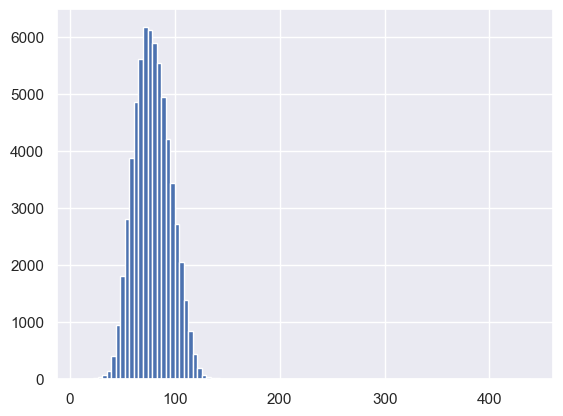

In [12]:
tau1p4 = getp4(df, vars=["pt_tau_1", "eta_tau_1", "phi_tau_1", "mass_tau_1"], LVtype="ptetaphim")
tau2p4 = getp4(df, vars=["pt_tau_2", "eta_tau_2", "phi_tau_2", "mass_tau_2"], LVtype="ptetaphim")

tausp4 = tau1p4 + tau2p4
print(tausp4.mass)
plt.hist(tausp4.mass, bins=100)
plt.show()
df["H_vism"] = tausp4.mass
target_keys = target_keys + ["H_vism"]

In [13]:
df_train, df_test = train_test_split(df,  test_size=0.2,  random_state=42, shuffle=True)

In [14]:
df_train_x = df_train.drop(columns=target_keys)
df_train_y = df_train[target_keys]

df_test_x = df_test.drop(columns=target_keys)
df_test_y = df_test[target_keys]

#df2_met_raw_phi_train = df_train_x[["met_phi_raw"]]
#df2_met_raw_phi_test  = df_test_x[["met_phi_raw"]]
#df_train_x = df_train_x.drop(columns=["met_phi_raw"])
#df_test_x = df_test_x.drop(columns=["met_phi_raw"])

feats = list(df_train_x.keys())

In [15]:
df_train_x

,pt_tau_1,pt_tau_2,eta_tau_1,eta_tau_2,phi_tau_1,phi_tau_2,mass_tau_1,mass_tau_2,dxy_tau_1,dxy_tau_2,dz_tau_1,dz_tau_2,rawIsodR03_tau_1,rawIsodR03_tau_2,leadTkPtOverTauPt_tau_1,leadTkPtOverTauPt_tau_2,rawPNetVSe_tau_1,rawPNetVSe_tau_2,rawPNetVSjet_tau_1,rawPNetVSjet_tau_2,rawPNetVSmu_tau_1,rawPNetVSmu_tau_2,probDM0PNet_tau_1,probDM0PNet_tau_2,probDM1PNet_tau_1,probDM1PNet_tau_2,probDM2PNet_tau_1,probDM2PNet_tau_2,probDM10PNet_tau_1,probDM10PNet_tau_2,probDM11PNet_tau_1,probDM11PNet_tau_2,pt_jet_1,pt_jet_2,pt_jet_3,pt_jet_4,eta_jet_1,eta_jet_2,eta_jet_3,eta_jet_4,phi_jet_1,phi_jet_2,phi_jet_3,phi_jet_4,mass_jet_1,mass_jet_2,mass_jet_3,mass_jet_4,btagPNetB_jet_1,btagPNetB_jet_2,btagPNetB_jet_3,btagPNetB_jet_4,npf_tau_1,npf_tau_2,ptfrac_tau_1,ptfrac_tau_2,pf_dphi_pt_frac_tau_1,pf_dphi_pt_frac_tau_2,pf_deta_pt_frac_tau_1,pf_deta_pt_frac_tau_2,pt_MET,phi_MET,covXX_MET,covXY_MET,covYY_MET,sumEt_MET,significance_MET,nJet,nPV,HT,MT_total,charge_-1_tau_1,charge_1_tau_1,charge_-1_tau_2,charge_1_tau_2,decayModePNet_0_tau_1,decayModePNet_1_tau_1,decayModePNet_2_tau_1,decayModePNet_10_tau_1,decayModePNet_11_tau_1,decayModePNet_0_tau_2,decayModePNet_1_tau_2,decayModePNet_2_tau_2,decayModePNet_10_tau_2,decayModePNet_11_tau_2
4283,29.592808,29.315573,0.112274,-0.955811,-2.616699,0.828491,0.900879,0.766602,-0.001087,-0.012718,-0.002020,0.012676,0.00000,1.044922,0.601562,0.093567,0.999023,0.999023,0.926270,0.941406,0.999512,0.999512,0.011826,0.007591,0.769043,0.571289,0.217529,0.418213,0.000688,0.000406,0.000868,0.002277,0.000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,2.0,2.0,0.999768,1.000162,-0.000297,-0.000061,0.012146,0.041504,15.375702,0.982056,222.5,0.00000,222.5,633.0,1.062500,2.0,6.0,72.937500,71.609842,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60331,54.130253,20.590471,-1.650146,-1.149414,-2.227539,2.297363,0.139526,0.713379,-0.000241,-0.000715,-0.042187,-0.008266,0.00000,0.000000,0.999512,0.779297,0.997559,0.999023,0.990234,0.971191,0.999512,0.999512,0.042877,0.027176,0.854004,0.883301,0.100891,0.088074,0.001689,0.001021,0.000737,0.000658,93.875,0.0000,0.0,0.0,0.457214,0.000000,0.0,0.0,0.161194,0.000000,0.0,0.0,11.062500,0.000000,0.0,0.0,0.006794,0.0,0.0,0.0,1.0,3.0,0.999903,1.000871,0.000000,0.000046,-0.000244,-0.029053,97.363617,-2.760254,744.0,13.59375,554.0,1523.0,13.140625,4.0,18.0,204.093750,82.206335,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43569,43.913177,34.384434,0.715576,1.530762,0.874390,-2.187988,0.772461,0.451660,-0.001534,-0.001145,0.000438,-0.001973,0.00000,0.000000,0.482910,0.493164,0.998535,0.997070,0.946289,0.764160,0.999512,0.999023,0.007385,0.033966,0.718262,0.796875,0.272461,0.166260,0.000624,0.001517,0.001363,0.001652,0.000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,4.0,3.0,1.000198,1.000180,0.000083,0.000112,-0.021240,-0.003906,31.327290,0.891235,260.0,22.81250,299.0,779.5,3.216797,3.0,15.0,127.843750,101.661866,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31708,33.200695,27.413704,-1.916992,-0.816284,-0.202942,-2.474121,0.139526,0.526367,0.001272,0.000511,0.004026,-0.001142,1.46875,0.000000,0.999512,0.609863,0.992188,0.999023,0.839844,0.911133,0.999023,0.999512,0.348633,0.012589,0.551758,0.779297,0.089661,0.205444,0.007034,0.001163,0.003046,0.001579,0.000,0.0000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,3.0,0.999603,1.000156,0.000000,-0.000068,0.000000,-0.007812,10.296808,1.527344,564.0,59.87500,451.0,1199.0,0.235962,4.0,17.0,123.437500,68.693206,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
50444,131.666611,81.182533,1.032227,0.437805,-3.004395,-2.270020,0.597168,0.776367,-0.000075,-0.000037,0.000145,0.004766,0.00000,0.577637,0.548828,0.697266,0.999023,0.999023,0.997070,0.993652,0.999512,0.999512,0.006500,0.017197,0.785156,0.882812,0.207520,0.099121,0.

In [16]:
df_train_y

,px_gentaunu_1,py_gentaunu_1,pz_gentaunu_1,px_gentaunu_2,py_gentaunu_2,pz_gentaunu_2,h1x,h1y,h1z,h2x,h2y,h2z,H_vism
4283,15.262535,14.785721,-22.849014,-24.122622,-14.460803,2.185727,0.702280,0.541070,-0.462650,-0.525930,-0.451183,0.720993,66.941640
60331,-31.412844,34.285320,-69.142967,-17.919260,-24.060343,-78.314507,-0.179072,0.913175,0.366122,0.109549,-0.930422,-0.349733,54.153333
43569,-3.546520,-4.761943,11.742276,26.738810,33.994095,33.404472,-0.348671,-0.936860,-0.026871,0.208741,0.811262,-0.546152,84.215667
31708,37.870926,-9.316269,-129.345428,-12.909749,-10.964365,-16.139336,0.744648,0.284739,-0.603674,-0.696408,-0.437874,0.568579,64.910033
50444,-19.361526,-22.505087,12.457897,-26.575607,-4.000342,31.908487,0.187575,-0.751144,-0.632929,-0.098560,0.779594,0.618481,96.964293
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62596,-4.993664,-35.399517,-6.618163,52.393990,-7.991861,38.605442,-0.632880,-0.518259,-0.575214,0.588341,0.448066,0.673121,52.026742
38176,13.083952,31.381685,-21.945965,-32.546005,-4.639320,12.070407,0.717371,0.577840,-0.389205,-0.718248,-0.523740,0.458056,57.569460
860,-13.840163,-4.726573,-30.606930,4.602334,1.175169,-2.956137,-0.830345,-0.252264,-0.496880,0.853172,0.218251,0.473776,94.354204
15803,-7.410548,11.767224,-1.838659,33.289062,2.393512,-11.665406,-0.903281,0.372785,0.212403,0.929506,-0.317051,-0.188409,58.211242


In [17]:
df_train_x.keys()

Index(['pt_tau_1', 'pt_tau_2', 'eta_tau_1', 'eta_tau_2', 'phi_tau_1',
       'phi_tau_2', 'mass_tau_1', 'mass_tau_2', 'dxy_tau_1', 'dxy_tau_2',
       'dz_tau_1', 'dz_tau_2', 'rawIsodR03_tau_1', 'rawIsodR03_tau_2',
       'leadTkPtOverTauPt_tau_1', 'leadTkPtOverTauPt_tau_2',
       'rawPNetVSe_tau_1', 'rawPNetVSe_tau_2', 'rawPNetVSjet_tau_1',
       'rawPNetVSjet_tau_2', 'rawPNetVSmu_tau_1', 'rawPNetVSmu_tau_2',
       'probDM0PNet_tau_1', 'probDM0PNet_tau_2', 'probDM1PNet_tau_1',
       'probDM1PNet_tau_2', 'probDM2PNet_tau_1', 'probDM2PNet_tau_2',
       'probDM10PNet_tau_1', 'probDM10PNet_tau_2', 'probDM11PNet_tau_1',
       'probDM11PNet_tau_2', 'pt_jet_1', 'pt_jet_2', 'pt_jet_3', 'pt_jet_4',
       'eta_jet_1', 'eta_jet_2', 'eta_jet_3', 'eta_jet_4', 'phi_jet_1',
       'phi_jet_2', 'phi_jet_3', 'phi_jet_4', 'mass_jet_1', 'mass_jet_2',
       'mass_jet_3', 'mass_jet_4', 'btagPNetB_jet_1', 'btagPNetB_jet_2',
       'btagPNetB_jet_3', 'btagPNetB_jet_4', 'npf_tau_1', 'npf_tau_2',
    

## Data engineering for LBN 

In [18]:
def dataset_LBN():    
    import vector
    df_train_x_copy = df_train_x.copy()
    df_test_x_copy = df_test_x.copy()

    def getp4(df, vars=[]):
        #for var in vars:
        #    if var not in list(df.keys()):
        #        df[var] = 0.0
        p4 = vector.array({"pt": df[vars[0]].to_numpy(),
                           "eta": df[vars[1]].to_numpy() if vars[1] in list(df.keys()) else np.zeros_like(df[vars[0]].to_numpy()),
                           "phi": df[vars[2]].to_numpy() if vars[2] in list(df.keys()) else np.zeros_like(df[vars[0]].to_numpy()),
                           "M": df[vars[3]].to_numpy() if vars[3] in list(df.keys()) else np.zeros_like(df[vars[0]].to_numpy())})

        return p4

    def setp4(df, vars=[]):
        p4 = getp4(df, vars=vars)
        obj = vars[0].split('_')[1]
        num = vars[0].split('_')[-1]
        key = f'{obj}_{num}' if len(vars[0].split('_')) > 2 else f'{obj}'

        df[f'px_{key}'] = p4.px
        df[f'py_{key}'] = p4.py
        df[f'pz_{key}'] = p4.pz
        df[f'E_{key}']  = p4.E



    Basics = [['pt_tau_1','eta_tau_1','phi_tau_1','mass_tau_1'],
              ['pt_tau_2','eta_tau_2','phi_tau_2','mass_tau_2'],
              ['pt_jet_1','eta_jet_1','phi_jet_1','mass_jet_1'],
              ['pt_jet_2','eta_jet_2','phi_jet_2','mass_jet_2'],
              ['pt_jet_3','eta_jet_3','phi_jet_3','mass_jet_3'],
              ['pt_jet_4','eta_jet_4','phi_jet_4','mass_jet_4'],
              ['pt_MET','eta_MET','phi_MET','mass_MET']]

    for varlist in Basics:
        setp4(df_train_x_copy, vars=varlist)
        setp4(df_test_x_copy, vars=varlist)


    DNNsToDrop = np.array(Basics).reshape(-1)    
    #print(DNNsToDrop)

    LBNsToKeep = np.char.replace(DNNsToDrop, "pt", "px")
    LBNsToKeep = np.char.replace(LBNsToKeep, "eta", "py")
    LBNsToKeep = np.char.replace(LBNsToKeep, "phi", "pz")
    LBNsToKeep = np.char.replace(LBNsToKeep, "mass", "E")
    LBNsToKeep = list(LBNsToKeep)
    #print(LBNsToKeep)

    #df_train_x_DNN = df_train_x_copy.drop(columns=list(DNNsToDrop)+LBNsToKeep)
    #df_test_x_DNN = df_test_x_copy.drop(columns=list(DNNsToDrop)+LBNsToKeep)
    df_train_x_DNN = df_train_x_copy.drop(columns=LBNsToKeep)
    df_test_x_DNN = df_test_x_copy.drop(columns=LBNsToKeep)

    df_train_x_LBN = df_train_x_copy[LBNsToKeep]
    df_test_x_LBN  = df_test_x_copy[LBNsToKeep]


    ##df_train_x_DNN
    ##df_train_x_DNN
    ##df_train_x_LBN
    ##df_test_x_LBN
    
    #cols_cat = [x for x in list(df_train_x_DNN.keys()) if x.split('_')[0] == 'cat']
    #cols_num = [x for x in list(df_train_x_DNN.keys()) if x.split('_')[0] != 'cat']
    
    x_train_DNN_numerical = df_train_x_DNN[num_keys].to_numpy()
    x_train_DNN_categorical = df_train_x_DNN[cat_keys].to_numpy()
    x_test_DNN_numerical = df_test_x_DNN[num_keys].to_numpy()
    x_test_DNN_categorical = df_test_x_DNN[cat_keys].to_numpy()

    #x_train_DNN = df_train_x_DNN.to_numpy()
    #x_test_DNN = df_test_x_DNN.to_numpy()

    ### ----- Scaling ----- ###
    scaler1 = preprocessing.StandardScaler()
    x_train_DNN_numerical = scaler1.fit_transform(x_train_DNN_numerical)
    x_test_DNN_numerical  = scaler1.transform(x_test_DNN_numerical)

    x_train_DNN = np.concatenate([x_train_DNN_numerical, x_train_DNN_categorical], axis=1)
    x_test_DNN  = np.concatenate([x_test_DNN_numerical, x_test_DNN_categorical], axis=1)
    ### ------------------- ###
    
    #x_train_DNN = df_train_x_DNN.to_numpy()
    #x_test_DNN  = df_test_x_DNN.to_numpy()
    
    x_train_LBN_ = df_train_x_LBN.to_numpy()
    x_test_LBN_ = df_test_x_LBN.to_numpy()

    ### ----- Scaling ----- ###
    #scaler2 = preprocessing.StandardScaler()
    #x_train_LBN_ = scaler2.fit_transform(x_train_LBN_)
    #x_test_LBN_  = scaler2.transform(x_test_LBN_)
    ### ------------------- ###
    
    x_train_LBN = x_train_LBN_.reshape(-1, x_train_LBN_.shape[-1]//4, 4)
    x_test_LBN = x_test_LBN_.reshape(-1, x_test_LBN_.shape[-1]//4, 4)

    print(x_train_LBN.shape, x_train_DNN.shape)
    print(x_train_LBN.shape, x_test_DNN.shape)
    
    """
    plt.figure(figsize=(20,20))
    for idx, key in enumerate(list(df_train_x_LBN.keys())):
        idx=idx+1
        ax = plt.subplot(7,4,idx)
        arr = x_train_LBN_[:,(idx-1):idx].reshape(-1)
        #print(arr)
        ax.hist(arr, 50, range=[np.min(arr), np.max(arr)], log=True)
        ax.set_title(f"{key}")
    plt.tight_layout()
    """

    feats_DNN = list(df_train_x_DNN.keys())
    
    dict = {'x_train': np.concatenate([x_train_DNN, x_train_LBN_], axis=1),
            'x_test': np.concatenate([x_test_DNN, x_test_LBN_], axis=1),
            'x_train_LBN_keys': list(df_train_x_LBN.keys()),
            'x_train_DNN_keys': list(df_train_x_DNN.keys()),
            'x_train_LBN': x_train_LBN,
            'x_test_LBN': x_test_LBN,
            'x_train_DNN': x_train_DNN,
            'x_test_DNN': x_test_DNN}
    return dict


In [19]:
LBN_dict = dataset_LBN()

feats_name_LBN = LBN_dict['x_train_LBN_keys']
feats_name_DNN = LBN_dict['x_train_DNN_keys']

x_train_LBN =  LBN_dict['x_train_LBN']
x_train_DNN =  LBN_dict['x_train_DNN']
x_test_LBN  =  LBN_dict['x_test_LBN']
x_test_DNN  =  LBN_dict['x_test_DNN']

(51635, 7, 4) (51635, 85)
(51635, 7, 4) (12909, 85)


In [20]:
len(feats_name_DNN), len(feats_name_LBN)

(85, 28)

In [21]:
feats = feats_name_LBN+feats_name_DNN if "LBN" in tag_ else feats
#feats = feats_name_DNN if tag_=="LBN" else feats
len(feats)

113

In [22]:
x_train = df_train_x.to_numpy()
y_train = df_train_y.to_numpy()

x_test = df_test_x.to_numpy()
y_test = df_test_y.to_numpy()

In [23]:
x_train.shape

(51635, 85)

In [24]:
#x_train[:,-12:]
x_train.shape, y_train.shape

((51635, 85), (51635, 13))

In [25]:
features = list(df_train_x.keys())
print(len(features))
targets = list(df_train_y.keys())
print(len(targets))

85
13


In [26]:
"""
scaler = preprocessing.StandardScaler()
x_train_ = scaler.fit_transform(x_train[:, :-12])
x_test_  = scaler.transform(x_test[:, :-12])

x_train = np.concatenate([x_train_, x_train[:,-12:]], axis=1)
x_test  = np.concatenate([x_test_, x_test[:,-12:]], axis=1)
"""

'\nscaler = preprocessing.StandardScaler()\nx_train_ = scaler.fit_transform(x_train[:, :-12])\nx_test_  = scaler.transform(x_test[:, :-12])\n\nx_train = np.concatenate([x_train_, x_train[:,-12:]], axis=1)\nx_test  = np.concatenate([x_test_, x_test[:,-12:]], axis=1)\n'

## Data batching 

In [27]:
#scaler = preprocessing.StandardScaler()
#y_train = scaler.fit_transform(y_train)
#y_test  = scaler.transform(y_test)

## Model subclassing 

In [28]:
#model = DNNModel()
y_train.shape

(51635, 13)

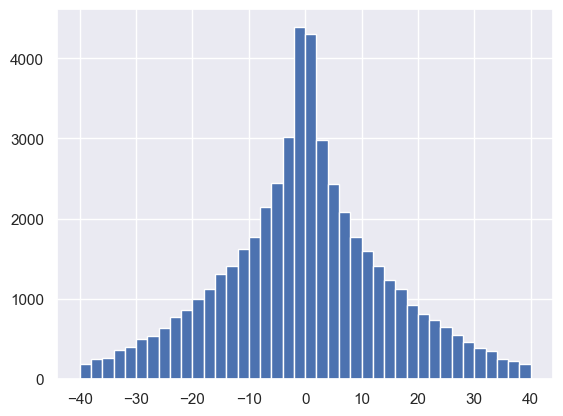

In [29]:
plt.hist(y_train[:,1], bins=40, range=[-40,40])
plt.show()

In [30]:
px_temp = y_train[:,1]
px_temp

array([ 14.78572083,  34.28532028,  -4.76194286, ...,  -4.72657299,
        11.76722431, -17.34933472])

In [31]:
np.mean(px_temp), np.std(px_temp)

(-0.24934615870813862, 19.68439288521732)

In [32]:
#wt = np.where(np.abs(px_temp) < np.std(px_temp), 1+np.abs(np.log(1/(px_temp**2))), 1.0)
#wt

In [33]:
wt = 1+np.abs(np.log(1/(px_temp**2)))
wt

array([6.38732381, 8.06943456, 4.1213115 , ..., 4.10640083, 5.93063613,
       6.70710832])

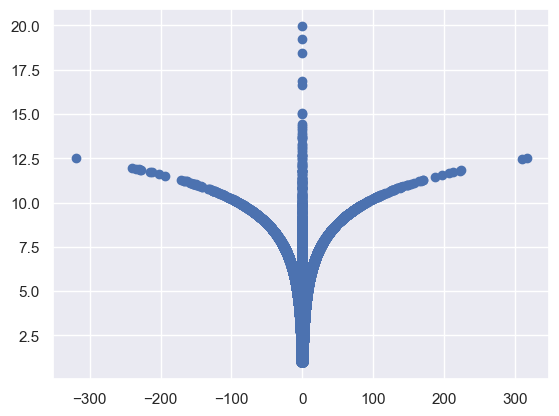

In [34]:
plt.scatter(px_temp, wt)

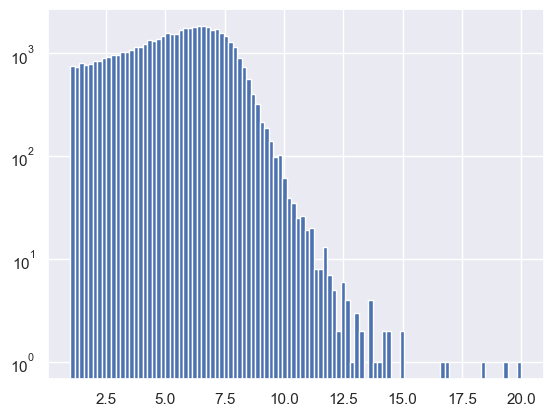

In [35]:
plt.hist(wt, bins=100, range=[1,20], log=True)
plt.show()

In [36]:
"""
plt.figure(figsize=(40,50))
for idx, key in enumerate(features):
    idx=idx+1
    ax = plt.subplot(13,6,idx)
    arr = x_train[:,(idx-1):idx].reshape(-1)
    #print(arr)
    ax.hist(arr, 50, range=[np.min(arr), np.max(arr)], log=True)
    ax.set_title(f"{key}")
plt.tight_layout()
"""

'\nplt.figure(figsize=(40,50))\nfor idx, key in enumerate(features):\n    idx=idx+1\n    ax = plt.subplot(13,6,idx)\n    arr = x_train[:,(idx-1):idx].reshape(-1)\n    #print(arr)\n    ax.hist(arr, 50, range=[np.min(arr), np.max(arr)], log=True)\n    ax.set_title(f"{key}")\nplt.tight_layout()\n'

In [37]:
#feats

In [38]:
inputs_all = []
for feat in feats:
    #print(feat)
    input_layer = Input(shape=(1,), name=feat)
    inputs_all.append(input_layer)
#print(inputs_all)
#print(len(inputs_all))
#print(inputs_all[1].shape)

all_features = tensorflow.keras.layers.concatenate(inputs_all,axis=-1,name="Features")

In [39]:
all_features

<KerasTensor: shape=(None, 113) dtype=float32 (created by layer 'Features')>

In [40]:
all_features[0][-1]

<KerasTensor: shape=() dtype=float32 (created by layer 'tf.__operators__.getitem_1')>

In [41]:
def buildmodel_DNN(input_layers, features):
    print("Building a DNN model")
    x = Dense(512, input_dim=features.shape[-1], activation='selu',
              kernel_regularizer=regularizers.l2(0.001))(features)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(7)(x)

    model_inputs = [input_layers]
    model = Model(inputs=model_inputs, outputs=[x])

    return model

In [42]:
def identity_block(X, layerinfo):
    X_shortcut = X
    for i, nodes in enumerate(layerinfo):
        X = Dense(nodes, kernel_regularizer=regularizers.l2(0.001))(X)
        X = Activation('selu')(X)
        X = BatchNormalization()(X)

    X = Add()([X, X_shortcut])
    X = Activation('selu')(X)

    return X

def conv_block(X, layerinfo):
    X_shortcut = X
    for i, nodes in enumerate(layerinfo):
        X = Dense(nodes, activation='selu', kernel_regularizer=regularizers.l2(0.0001))(X)
        #X = Activation('selu')(X)
        #X = BatchNormalization()(X)

    #X_shortcut = Dense(layerinfo[-1])(X)
    X_shortcut = Dense(layerinfo[-1])(X_shortcut)
    #X_shortcut = BatchNormalization()(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('selu')(X)
    X = BatchNormalization()(X)

    return X

def buildmodel_Resnet(input_layers, features):
    print("Building a SkipNetwork DNN model")
    X = Dense(512, input_dim=features.shape[-1], activation='selu',
              kernel_regularizer=regularizers.l2(0.0001))(features)
    X = BatchNormalization()(X)
    X = Dropout(0.1)(X)

    X = conv_block(X, [512, 512, 512])
    X = Dropout(0.1)(X)
    X = conv_block(X, [256, 256, 256])
    X = Dropout(0.1)(X)
    X = conv_block(X, [128, 128, 128])
    X = Dropout(0.1)(X)
    X = conv_block(X, [64, 64, 64])
    X = Dropout(0.1)(X)
    X = Dense(7)(X)


    model_inputs = [input_layers]
    print(f"model_inputs: {model_inputs}")
    model = Model(inputs=model_inputs, outputs=[X])

    return model

In [43]:
def buildmodel_LBN(inputs_all, x_train_LBN, all_features):
    print("Building a LBN model")
    input_lbn_Layer = tensorflow.keras.Input(shape=x_train_LBN.shape[1:],name='LBN_inputs')
    print(f'type & shape of lbn input: {type(input_lbn_Layer)}, {input_lbn_Layer.shape}')

    lbn_layer = LBNLayer(x_train_LBN.shape[1:],
                         n_particles = 7,
                         boost_mode  = LBN.PAIRS,
                         features    = ["E", "px", "py", "pz", "pt", "p", "phi","eta", "m", "pair_cos"],
                         #features    = ["E","px","py","pz","pt","p","m","phi","eta","beta","gamma","pair_cos","pair_dr","pair_ds","pair_dy"],
                         name='LBN')(input_lbn_Layer)
    print(f'Type & shape of LBN layer : {type(lbn_layer)}')

    batchnorm = tensorflow.keras.layers.BatchNormalization(name='batchnorm')(lbn_layer)
    print(f'type & shape of batchnorm : {type(batchnorm)}, {batchnorm.shape}')

    concat = tensorflow.keras.layers.Concatenate(axis=-1)([all_features, batchnorm])
    print(f'Concatenated shape : {concat.shape}')
    print(f'Concatenated type  : {type(concat)}')


    x = Dense(512, activation='selu', kernel_regularizer=regularizers.l2(0.001))(concat)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='selu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(8)(x)

    model_inputs = [inputs_all]
    model_inputs.append(input_lbn_Layer)
    print(model_inputs)
    model = Model(inputs=model_inputs, outputs=[x])

    return model

In [44]:
def buildmodel_LBN_ResNet(inputs_all, x_train_LBN, all_features):
    print("Building a LBN with skip connection model") 
    input_lbn_Layer = tensorflow.keras.Input(shape=x_train_LBN.shape[1:],name='LBN_inputs')
    print(f'type & shape of lbn input: {type(input_lbn_Layer)}, {input_lbn_Layer.shape}')

    lbn_layer = LBNLayer(x_train_LBN.shape[1:],
                         n_particles = 5,
                         boost_mode  = LBN.PAIRS,
                         features    = ["E", "px", "py", "pz", "pt", "eta", "phi", "p", "m", "pair_cos","pair_dr"],
                         #features    = ["E","px","py","pz","pt","p","m","phi","eta","beta","gamma","pair_cos","pair_dr","pair_ds","pair_dy"],
                         name='LBN')(input_lbn_Layer)
    print(f'Type & shape of LBN layer : {type(lbn_layer)}')

    batchnorm = tensorflow.keras.layers.BatchNormalization(name='batchnorm')(lbn_layer)
    print(f'type & shape of batchnorm : {type(batchnorm)}, {batchnorm.shape}')

    concat = tensorflow.keras.layers.Concatenate(axis=-1)([all_features, batchnorm])
    print(f'Concatenated shape : {concat.shape}')
    print(f'Concatenated type  : {type(concat)}')


    #x = Dense(512, activation='selu', kernel_regularizer=regularizers.l2(0.001))(concat)
    #x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)

    #x = conv_block(concat, [1028, 1028])
    #x = Dropout(0.1)(x)
    x = conv_block(concat, [512, 512, 512])
    x = Dropout(0.1)(x)
    x = conv_block(x, [256, 256, 256])
    x = Dropout(0.1)(x)
    x = conv_block(x, [256, 256, 256])
    x = Dropout(0.1)(x)
    x = conv_block(x, [128, 128, 128])
    x = Dropout(0.1)(x)
    #x = Dense(8)(x)
    x = Dense(13)(x)

    model_inputs = [inputs_all]
    model_inputs.append(input_lbn_Layer)
    print(model_inputs)
    model = Model(inputs=model_inputs, outputs=[x])

    return model

In [45]:
def getmodel(input_layers=inputs_all, x_train_LBN=x_train_LBN, features=all_features, tag=tag_):
    model = None
    tag_split = tag_.split('_')[0]
    if tag_split=="DNN":
        model = buildmodel_DNN(input_layers, features)
    elif tag_split=="LBN":
        model = buildmodel_LBN(input_layers, x_train_LBN, features)
    elif tag_split=="ResNet":
        model = buildmodel_Resnet(input_layers, features)
    elif tag_split=="LBNResNet":
        model = buildmodel_LBN_ResNet(input_layers, x_train_LBN, features)
    else:
        print("Run DNN as no tag mentioned")
        model = buildmodel_DNN(input_layers, features)

    return model

In [46]:
model = getmodel(tag=tag_)
model.summary()

Building a LBN with skip connection model
type & shape of lbn input: <class 'keras.src.engine.keras_tensor.KerasTensor'>, (None, 7, 4)
Type & shape of LBN layer : <class 'keras.src.engine.keras_tensor.KerasTensor'>
type & shape of batchnorm : <class 'keras.src.engine.keras_tensor.KerasTensor'>, (None, 65)
Concatenated shape : (None, 178)
Concatenated type  : <class 'keras.src.engine.keras_tensor.KerasTensor'>
[[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'px_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'py_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pz_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'E_tau_1')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'px_tau_2')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'py_tau_2')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pz_tau_2')>, <KerasTensor: shape=(None, 1) dtype=float32 (created b

__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 LBN_inputs (InputLayer)     [(None, 7, 4)]               0         []                            
                                                                                                  
 px_tau_1 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 py_tau_1 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 pz_tau_1 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 E_tau_1 (

 dz_tau_2 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 rawIsodR03_tau_1 (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 rawIsodR03_tau_2 (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 leadTkPtOverTauPt_tau_1 (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
          

                                                                                                  
 phi_jet_4 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 mass_jet_1 (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 mass_jet_2 (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 mass_jet_3 (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 mass_jet_4 (InputLayer)     [(None, 1)]                  0         []                            
          

                                                                                                  
 decayModePNet_2_tau_1 (Inp  [(None, 1)]                  0         []                            
 utLayer)                                                                                         
                                                                                                  
 decayModePNet_10_tau_1 (In  [(None, 1)]                  0         []                            
 putLayer)                                                                                        
                                                                                                  
 decayModePNet_11_tau_1 (In  [(None, 1)]                  0         []                            
 putLayer)                                                                                        
                                                                                                  
 decayMode

                                                                     'probDM2PNet_tau_1[0][0]',   
                                                                     'probDM2PNet_tau_2[0][0]',   
                                                                     'probDM10PNet_tau_1[0][0]',  
                                                                     'probDM10PNet_tau_2[0][0]',  
                                                                     'probDM11PNet_tau_1[0][0]',  
                                                                     'probDM11PNet_tau_2[0][0]',  
                                                                     'pt_jet_1[0][0]',            
                                                                     'pt_jet_2[0][0]',            
                                                                     'pt_jet_3[0][0]',            
                                                                     'pt_jet_4[0][0]',            
          

                                                                     'dense_3[0][0]']             
                                                                                                  
 activation (Activation)     (None, 512)                  0         ['add[0][0]']                 
                                                                                                  
 batch_normalization (Batch  (None, 512)                  2048      ['activation[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 512)                  0         ['batch_normalization[0][0]'] 
                                                                                                  
 dense_4 (Dense)             (None, 256)                  131328    ['dropout[0][0]']             
          

In [47]:
# Compile and fit
#set early stopping monitor so the model stops training when it won't improve anymore                                                                     
#early_stopping_monitor = EarlyStopping(patience=3)                                                                                                       
# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd                                              
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    #patience=int(nEpoch/10),
    patience=20,                                                                                                                                         
    min_delta=0.0001,
    verbose=1,
    restore_best_weights=True,
    #restore_best_weights=False,                                                                                                                          
    mode='min'
    #mode='max'                                                                                                                                           
)
#https://keras.io/api/callbacks/reduce_lr_on_plateau/                                                                                                     
custom_ReduceLROnPlateau = ReduceLROnPlateau(
    monitor="val_loss",
    #monitor="loss",                                                                                                                  
    factor=0.5, #0.1
    #patience=5,                                                                                                                                          
    patience=10,
    verbose=1,
    mode="min",
    #mode="max",                                                                                                                                          
    cooldown=0,                                                                                                                                          
    #cooldown=5,
    #min_lr=0
    min_lr=1e-10,                                                                                                                                         
    min_delta=0.0001                                                                                                                                      
)
#custom loss-history with batch
#https://github.com/cp3-llbb/HHbbWWAnalysis/blob/master/MachineLearning/HHMachineLearning/Model.py#L47
class LossHistory(Callback):
    """ Records the history of the training per epoch and per batch """
    def on_train_begin(self, logs={}):
        self.epochs  = defaultdict(list) 
        self.batches = defaultdict(list) 
        self.pre_batch = 0

    def on_batch_end(self, batch, logs={}):
        self.batches['batch'].append(batch+self.pre_batch)
        for key,val in logs.items():
            self.batches[key].append(val)
        self.batches['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
        #loss = logs.get('loss')
        #print(f'\nBatch : {batch} with average loss : {loss}')

    def on_epoch_end(self, epoch, logs={}):
        self.epochs['epoch'].append(epoch)
        for key,val in logs.items():
            self.epochs[key].append(val)
        #self.epochs['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
        self.pre_batch = self.batches['batch'][-1] 

In [48]:
#print(x_train.shape)
#fit_inputs = np.hsplit(x_train,x_train.shape[1])
#print(len(fit_inputs))

x_train = LBN_dict['x_train'] if "LBN" in tag_ else x_train
x_test  = LBN_dict['x_test'] if "LBN" in tag_ else x_test
#x_train = x_train_DNN if tag_=="LBN" else x_train
#x_test  = x_test_DNN if tag_=="LBN" else x_test


print(x_train.shape)
fit_inputs = np.hsplit(x_train, x_train.shape[1])
print(len(fit_inputs))
if "LBN" in tag_:
    fit_inputs.append(x_train_LBN)

print(len(fit_inputs))
print(fit_inputs[0].shape)
print(fit_inputs[-1].shape)


fit_tests = np.hsplit(x_test, x_test.shape[1])
if "LBN" in tag_:
    fit_tests.append(x_test_LBN)


(51635, 113)
113
114
(51635, 1)
(51635, 7, 4)


In [49]:
#x_dataset = []
#batchlen = 2000
#for i in range(len(fit_inputs)):
#    temp = tf.data.Dataset.from_tensor_slices(fit_inputs[i]).batch(batchlen)
#    print(temp)
#    x_dataset.append(temp)

In [50]:
#x_dataset = tf.data.Dataset.from_tensor_slices(fit_inputs)
#y_dataset = tf.data.Dataset.from_tensor_slices(y_train).batch(batchlen)

In [51]:
#y_dataset

In [52]:
# Convert datasets to NumPy arrays
#x_values = np.array(list(x_dataset.as_numpy_iterator()))
#y_values = np.array(list(y_dataset.as_numpy_iterator()))

In [53]:
#y_values.shape

In [54]:
#x_dataset = x_dataset.batch(1000)
#y_dataset = y_dataset.batch(1000)

In [55]:
#dataset = dataset.batch(5000)
#dataset

In [56]:
#x_data = np.random.random((50000, 10))  # Assuming you have 10 features
#y_data = np.random.random((50000, 1))

# Create a TensorFlow dataset from your data
#dataset = tf.data.Dataset.from_tensor_slices(x_data)

In [57]:
#dataset

In [58]:
#dataset = dataset.map(lambda x, y: (x, y))

In [59]:
#dataset

In [60]:
451997%2048

1437

In [61]:
def custom_loss():
    def loss(y_true, y_pred):
        print(f"y_true: {y_true}")
        print(f"y_pred: {y_pred}")
        #lbn_input = np.array(x_input[-1])
        #print(f"x_input: {lbn_input.shape}")
        #print("Check y in detail")
        print(y_true[:,:1], y_pred[:,:1])
        print(y_true[:,1:2], y_pred[:,1:2])
        print(y_true[:,2:3], y_pred[:,2:3])
        #x = tf.convert_to_tensor(x_input)
        #print(f'x: {x[:,:1]}')
        """
        tau1_p4 = x_lbn_input[:y_pred.shape[0],0:1,:].reshape(y_pred.shape[0],4)
        tau2_p4 = x_lbn_input[:y_pred.shape[0],1:2,:].reshape(y_pred.shape[0],4)
        #print(f"tau1 : {x_lbn_input[:,:1,:].reshape(x_lbn_input.shape[0],4)}")
        lvadd_tau1nu1_pred = tf.add(y_pred[:,:4], tau1_p4)
        lvadd_tau1nu1_true = tf.add(y_true[:,:4], tau1_p4)
        print(f"lvadd_tau1nu1_pred: {lvadd_tau1nu1_pred}")

        lvadd_tau2nu2_pred = tf.add(y_pred[:,4:8], tau2_p4)
        lvadd_tau2nu2_true = tf.add(y_true[:,4:8], tau2_p4)

        energy_tau1nu1_pred = lvadd_tau1nu1_pred[:, 0]
        momentum_tau1nu1_pred = tf.norm(lvadd_tau1nu1_pred[:, 1:], axis=1)
        mass_tau1nu1_pred = tf.sqrt(energy_tau1nu1_pred ** 2 - momentum_tau1nu1_pred ** 2)

        energy_tau1nu1_true = lvadd_tau1nu1_true[:, 0]
        momentum_tau1nu1_true = tf.norm(lvadd_tau1nu1_true[:, 1:], axis=1)
        mass_tau1nu1_true = tf.sqrt(energy_tau1nu1_true ** 2 - momentum_tau1nu1_true ** 2)

        energy_tau2nu2_pred = lvadd_tau2nu2_pred[:, 0]
        momentum_tau2nu2_pred = tf.norm(lvadd_tau2nu2_pred[:, 1:], axis=1)
        mass_tau2nu2_pred = tf.sqrt(energy_tau2nu2_pred ** 2 - momentum_tau2nu2_pred ** 2)

        energy_tau2nu2_true = lvadd_tau2nu2_true[:, 0]
        momentum_tau2nu2_true = tf.norm(lvadd_tau2nu2_true[:, 1:], axis=1)
        mass_tau2nu2_true = tf.sqrt(energy_tau2nu2_true ** 2 - momentum_tau2nu2_true ** 2)


        mass = tf.reduce_mean(tf.add(tf.square(mass_tau1nu1_true - mass_tau1nu1_pred), tf.square(mass_tau2nu2_true - mass_tau2nu2_pred)))

        #tau_mass_pred = tf.reduce_mean(tf.add(mass_tau1nu1_pred, mass_tau2nu2_pred))
        #tau_mass_true = tf.reduce_mean(tf.add(mass_tau1nu1_true, mass_tau2nu2_true))

        #massterm = tf.square(tau_mass_pred - tau_mass_true)

        print(f"mass: {mass}")
        """
        se = tf.square(y_true[:,:-1]-y_pred[:,:-1])
        #mse = tf.reduce_mean(se)
        mass = tf.square(y_true[:,-1:] - y_pred[:,-1:])
        #mass = tf.reduce_mean(mass)
        #mse = tf.cast(mse, tf.float64)
        # print(f"mse: {mse}")
        return tf.reduce_mean(tf.add(se,mass))
        #return tf.add(mse, mass)
    return loss


def huber_loss(y_true, y_pred, threshold):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold     
    small_error_loss = tf.square(error) / 2     
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    loss = tf.where(is_small_error, small_error_loss, big_error_loss)
    #mean_loss = tf.reduce_mean(loss)
    #print(f"Loss: {loss}")
    return loss

def custom_loss_2(threshold=1.0, beta=2.0):
    def huber_loss_mean(y_true, y_pred):
        huber_loss_val = tf.reduce_mean(huber_loss(y_true[:,:-1], y_pred[:,:-1], threshold), 1)
        print(f"huber_loss_val: {huber_loss_val}")
        mass_huber_loss_val = huber_loss(y_true[:,-1], y_pred[:,-1], threshold)
        print(f"mass_huber_loss_val: {mass_huber_loss_val}")
        loss = tf.reduce_mean(tf.add(huber_loss_val, beta*mass_huber_loss_val))  
        return loss
    return huber_loss_mean

def custom_loss_3(alpha=1.0, beta=1.0):
    def comp_loss(y_true, y_pred):
        #mae_loss_val = tf.reduce_sum(tf.abs(y_true[:,:-1] - y_pred[:,:-1]))
        mae_loss_val = alpha*tf.abs(y_true[:,:-1] - y_pred[:,:-1])
        #mae_loss_val = tf.cumsum(mae_loss_val, 1)
        print(f"mae_loss_val: {mae_loss_val}")
        #mass_loss_val = tf.reduce_sum(beta*((y_pred[:,-1]/y_true[:,-1]) - 1))
        mass_loss_val = tf.abs(beta*((y_pred[:,-1]/y_true[:,-1]) - 1))
        print(f"mass_loss_val: {mass_loss_val}")
        loss = tf.concat([mae_loss_val, tf.reshape(mass_loss_val, [-1,1])], 1)
        #loss = tf.reduce_sum(loss)
        loss = tf.reduce_mean(tf.reduce_sum(loss, 1))
        return loss
    return comp_loss

In [62]:
t1 = [[1, 2, 3], [4, 5, 6]]
t1 = tf.reshape(t1, [-1])
t2 = tf.reshape(t1, [-1,1])
t2

<tf.Tensor: shape=(6, 1), dtype=int32, numpy=
array([[1],
       [2],
       [3],
       [4],
       [5],
       [6]], dtype=int32)>

In [63]:
loss_history = LossHistory()
#y_pred = model.evaluate()
#tau1phi = df_train_x["tau_1_phi"].to_numpy()
#tau1phi = np.abs(tau1phi)
model.compile(loss=custom_loss_3(), #tensorflow.keras.losses.Huber(), tensorflow.keras.losses.Huber(), custom_loss(fit_inputs), custom_loss(x_train_LBN), custom_loss_1(df_train_x), tensorflow.keras.losses.Huber(), custom_loss_1(tau1phi),
              optimizer=tensorflow.keras.optimizers.legacy.Adam(learning_rate=0.01),
              metrics=[tensorflow.keras.metrics.R2Score(),
                       tensorflow.keras.metrics.MeanAbsoluteError(),
                       tensorflow.keras.metrics.MeanAbsolutePercentageError()])


log_dir = f"{tag_}/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

datetime_tag = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_path = f"{tagdir}/training_{datetime_tag}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback_list = [#custom_early_stopping,
                 custom_ReduceLROnPlateau,
                 loss_history,
                 tensorboard_callback,
                 cp_callback]

In [64]:
#history = None
#if train:
history = model.fit(fit_inputs,
                    y_train,
                    epochs=300,
                    batch_size=3000,
                    validation_split=0.2,
                    #sample_weight=wt,
                    verbose=1,
                    use_multiprocessing=True,
                    callbacks=callback_list)

Epoch 1/300
mae_loss_val: Tensor("comp_loss/mul:0", shape=(None, 12), dtype=float32)
mass_loss_val: Tensor("comp_loss/Abs_1:0", shape=(None,), dtype=float32)
mae_loss_val: Tensor("comp_loss/mul:0", shape=(None, 12), dtype=float32)
mass_loss_val: Tensor("comp_loss/Abs_1:0", shape=(None,), dtype=float32)
14/14 [==============================] - ETA: 0s - loss: 100.1800 - r2_score: -3.1891 - mean_absolute_error: 13.6201 - mean_absolute_percentage_error: 851.1011mae_loss_val: Tensor("comp_loss/mul:0", shape=(None, 12), dtype=float32)
mass_loss_val: Tensor("comp_loss/Abs_1:0", shape=(None,), dtype=float32)

Epoch 1: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 3s 162ms/step - loss: 100.1800 - r2_score: -3.1891 - mean_absolute_error: 13.6201 - mean_absolute_percentage_error: 851.1011 - val_loss: 7714.2827 - val_r2_score: -16201.3232 - val_mean_absolute_error: 664.5065 - val

Epoch 14/300
14/14 [==============================] - ETA: 0s - loss: 87.5016 - r2_score: 0.0720 - mean_absolute_error: 7.7115 - mean_absolute_percentage_error: 633.2385
Epoch 14: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 152ms/step - loss: 87.5016 - r2_score: 0.0720 - mean_absolute_error: 7.7115 - mean_absolute_percentage_error: 633.2385 - val_loss: 87.5122 - val_r2_score: 0.0969 - val_mean_absolute_error: 7.5934 - val_mean_absolute_percentage_error: 205.7761 - lr: 0.0100
Epoch 15/300
14/14 [==============================] - ETA: 0s - loss: 87.3373 - r2_score: 0.0789 - mean_absolute_error: 7.6833 - mean_absolute_percentage_error: 829.1481
Epoch 15: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 145ms/step - loss: 87.3373 - r2_score: 0.0789 - 

Epoch 28/300
14/14 [==============================] - ETA: 0s - loss: 80.4625 - r2_score: 0.1733 - mean_absolute_error: 7.2040 - mean_absolute_percentage_error: 856.2311
Epoch 28: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 145ms/step - loss: 80.4625 - r2_score: 0.1733 - mean_absolute_error: 7.2040 - mean_absolute_percentage_error: 856.2311 - val_loss: 89.0299 - val_r2_score: 0.0736 - val_mean_absolute_error: 8.0376 - val_mean_absolute_percentage_error: 369.6237 - lr: 0.0100
Epoch 29/300
14/14 [==============================] - ETA: 0s - loss: 80.0749 - r2_score: 0.1766 - mean_absolute_error: 7.1688 - mean_absolute_percentage_error: 604.1042
Epoch 29: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 142ms/step - loss: 80.0749 - r2_score: 0.1766 - 

Epoch 42/300
14/14 [==============================] - ETA: 0s - loss: 68.1090 - r2_score: 0.3538 - mean_absolute_error: 6.2237 - mean_absolute_percentage_error: 714.4816
Epoch 42: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 143ms/step - loss: 68.1090 - r2_score: 0.3538 - mean_absolute_error: 6.2237 - mean_absolute_percentage_error: 714.4816 - val_loss: 78.0720 - val_r2_score: 0.2627 - val_mean_absolute_error: 6.9420 - val_mean_absolute_percentage_error: 480.5067 - lr: 0.0100
Epoch 43/300
14/14 [==============================] - ETA: 0s - loss: 67.3720 - r2_score: 0.3729 - mean_absolute_error: 6.1148 - mean_absolute_percentage_error: 525.2889
Epoch 43: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 148ms/step - loss: 67.3720 - r2_score: 0.3729 - 

Epoch 56/300
14/14 [==============================] - ETA: 0s - loss: 60.2901 - r2_score: 0.4653 - mean_absolute_error: 5.5299 - mean_absolute_percentage_error: 342.3866
Epoch 56: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 147ms/step - loss: 60.2901 - r2_score: 0.4653 - mean_absolute_error: 5.5299 - mean_absolute_percentage_error: 342.3866 - val_loss: 63.6572 - val_r2_score: 0.4725 - val_mean_absolute_error: 5.6400 - val_mean_absolute_percentage_error: 389.6905 - lr: 0.0100
Epoch 57/300
14/14 [==============================] - ETA: 0s - loss: 59.3057 - r2_score: 0.4804 - mean_absolute_error: 5.4639 - mean_absolute_percentage_error: 552.7751
Epoch 57: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 146ms/step - loss: 59.3057 - r2_score: 0.4804 - 

Epoch 70/300
14/14 [==============================] - ETA: 0s - loss: 44.5390 - r2_score: 0.7431 - mean_absolute_error: 4.0876 - mean_absolute_percentage_error: 561.3741
Epoch 70: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 149ms/step - loss: 44.5390 - r2_score: 0.7431 - mean_absolute_error: 4.0876 - mean_absolute_percentage_error: 561.3741 - val_loss: 51.3867 - val_r2_score: 0.7070 - val_mean_absolute_error: 4.7303 - val_mean_absolute_percentage_error: 487.5643 - lr: 0.0100
Epoch 71/300
14/14 [==============================] - ETA: 0s - loss: 43.6432 - r2_score: 0.7501 - mean_absolute_error: 4.0314 - mean_absolute_percentage_error: 488.6926
Epoch 71: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 146ms/step - loss: 43.6432 - r2_score: 0.7501 - 

Epoch 84/300
14/14 [==============================] - ETA: 0s - loss: 39.2538 - r2_score: 0.7998 - mean_absolute_error: 3.6494 - mean_absolute_percentage_error: 457.4069
Epoch 84: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 147ms/step - loss: 39.2538 - r2_score: 0.7998 - mean_absolute_error: 3.6494 - mean_absolute_percentage_error: 457.4069 - val_loss: 46.2619 - val_r2_score: 0.7914 - val_mean_absolute_error: 4.0713 - val_mean_absolute_percentage_error: 411.7176 - lr: 0.0100
Epoch 85/300
14/14 [==============================] - ETA: 0s - loss: 39.1488 - r2_score: 0.7971 - mean_absolute_error: 3.6359 - mean_absolute_percentage_error: 461.7411
Epoch 85: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 143ms/step - loss: 39.1488 - r2_score: 0.7971 - 

Epoch 98/300
14/14 [==============================] - ETA: 0s - loss: 37.4503 - r2_score: 0.8148 - mean_absolute_error: 3.4945 - mean_absolute_percentage_error: 453.2874
Epoch 98: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 145ms/step - loss: 37.4503 - r2_score: 0.8148 - mean_absolute_error: 3.4945 - mean_absolute_percentage_error: 453.2874 - val_loss: 43.9213 - val_r2_score: 0.8239 - val_mean_absolute_error: 3.6731 - val_mean_absolute_percentage_error: 330.9167 - lr: 0.0100
Epoch 99/300
14/14 [==============================] - ETA: 0s - loss: 37.6408 - r2_score: 0.8104 - mean_absolute_error: 3.5077 - mean_absolute_percentage_error: 401.7132
Epoch 99: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 148ms/step - loss: 37.6408 - r2_score: 0.8104 - 

14/14 [==============================] - 2s 141ms/step - loss: 34.1727 - r2_score: 0.8366 - mean_absolute_error: 3.2428 - mean_absolute_percentage_error: 287.0762 - val_loss: 42.2776 - val_r2_score: 0.8481 - val_mean_absolute_error: 3.5092 - val_mean_absolute_percentage_error: 291.1036 - lr: 0.0050
Epoch 112/300
14/14 [==============================] - ETA: 0s - loss: 33.8021 - r2_score: 0.8381 - mean_absolute_error: 3.2119 - mean_absolute_percentage_error: 288.0838
Epoch 112: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 151ms/step - loss: 33.8021 - r2_score: 0.8381 - mean_absolute_error: 3.2119 - mean_absolute_percentage_error: 288.0838 - val_loss: 42.3945 - val_r2_score: 0.8508 - val_mean_absolute_error: 3.4980 - val_mean_absolute_percentage_error: 292.4972 - lr: 0.0050
Epoch 113/300
14/14 [==============================] - ETA: 0s - loss: 33.6492 - r2_score: 0.8

Epoch 125/300
14/14 [==============================] - ETA: 0s - loss: 31.3383 - r2_score: 0.8529 - mean_absolute_error: 3.0269 - mean_absolute_percentage_error: 399.4160
Epoch 125: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 158ms/step - loss: 31.3383 - r2_score: 0.8529 - mean_absolute_error: 3.0269 - mean_absolute_percentage_error: 399.4160 - val_loss: 42.5861 - val_r2_score: 0.8542 - val_mean_absolute_error: 3.5237 - val_mean_absolute_percentage_error: 268.8509 - lr: 0.0025
Epoch 126/300
14/14 [==============================] - ETA: 0s - loss: 31.3404 - r2_score: 0.8522 - mean_absolute_error: 3.0283 - mean_absolute_percentage_error: 396.1761
Epoch 126: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 158ms/step - loss: 31.3404 - r2_score: 0.852

14/14 [==============================] - 3s 189ms/step - loss: 29.8303 - r2_score: 0.8576 - mean_absolute_error: 2.9177 - mean_absolute_percentage_error: 316.7990 - val_loss: 42.6080 - val_r2_score: 0.8557 - val_mean_absolute_error: 3.5300 - val_mean_absolute_percentage_error: 264.4964 - lr: 0.0012
Epoch 139/300
14/14 [==============================] - ETA: 0s - loss: 29.9546 - r2_score: 0.8573 - mean_absolute_error: 2.9282 - mean_absolute_percentage_error: 315.9015
Epoch 139: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.

Epoch 139: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 160ms/step - loss: 29.9546 - r2_score: 0.8573 - mean_absolute_error: 2.9282 - mean_absolute_percentage_error: 315.9015 - val_loss: 42.6497 - val_r2_score: 0.8542 - val_mean_absolute_error: 3.5169 - val_mean_absolute_percentage_error: 256.9926 - lr: 0.0012
Epoch 140/300
1

Epoch 152/300
14/14 [==============================] - ETA: 0s - loss: 28.9280 - r2_score: 0.8612 - mean_absolute_error: 2.8490 - mean_absolute_percentage_error: 308.3482
Epoch 152: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 146ms/step - loss: 28.9280 - r2_score: 0.8612 - mean_absolute_error: 2.8490 - mean_absolute_percentage_error: 308.3482 - val_loss: 41.9640 - val_r2_score: 0.8583 - val_mean_absolute_error: 3.4668 - val_mean_absolute_percentage_error: 259.7515 - lr: 3.1250e-04
Epoch 153/300
14/14 [==============================] - ETA: 0s - loss: 28.9048 - r2_score: 0.8605 - mean_absolute_error: 2.8489 - mean_absolute_percentage_error: 400.7106
Epoch 153: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 146ms/step - loss: 28.9048 - r2_score: 0

14/14 [==============================] - 2s 180ms/step - loss: 28.6463 - r2_score: 0.8614 - mean_absolute_error: 2.8346 - mean_absolute_percentage_error: 371.4101 - val_loss: 41.9418 - val_r2_score: 0.8586 - val_mean_absolute_error: 3.4700 - val_mean_absolute_percentage_error: 264.9353 - lr: 1.5625e-04
Epoch 166/300
14/14 [==============================] - ETA: 0s - loss: 28.6131 - r2_score: 0.8631 - mean_absolute_error: 2.8274 - mean_absolute_percentage_error: 253.5343
Epoch 166: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 161ms/step - loss: 28.6131 - r2_score: 0.8631 - mean_absolute_error: 2.8274 - mean_absolute_percentage_error: 253.5343 - val_loss: 41.9589 - val_r2_score: 0.8583 - val_mean_absolute_error: 3.4714 - val_mean_absolute_percentage_error: 262.3283 - lr: 1.5625e-04
Epoch 167/300
14/14 [==============================] - ETA: 0s - loss: 28.6595 - r2_sc

Epoch 179/300
14/14 [==============================] - ETA: 0s - loss: 28.5840 - r2_score: 0.8612 - mean_absolute_error: 2.8316 - mean_absolute_percentage_error: 371.4546
Epoch 179: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.

Epoch 179: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 161ms/step - loss: 28.5840 - r2_score: 0.8612 - mean_absolute_error: 2.8316 - mean_absolute_percentage_error: 371.4546 - val_loss: 41.9921 - val_r2_score: 0.8585 - val_mean_absolute_error: 3.4797 - val_mean_absolute_percentage_error: 267.6884 - lr: 7.8125e-05
Epoch 180/300
14/14 [==============================] - ETA: 0s - loss: 28.5520 - r2_score: 0.8613 - mean_absolute_error: 2.8285 - mean_absolute_percentage_error: 316.4286
Epoch 180: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/1

14/14 [==============================] - ETA: 0s - loss: 28.5111 - r2_score: 0.8617 - mean_absolute_error: 2.8219 - mean_absolute_percentage_error: 445.4148
Epoch 192: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 150ms/step - loss: 28.5111 - r2_score: 0.8617 - mean_absolute_error: 2.8219 - mean_absolute_percentage_error: 445.4148 - val_loss: 42.0507 - val_r2_score: 0.8581 - val_mean_absolute_error: 3.4852 - val_mean_absolute_percentage_error: 266.8994 - lr: 1.9531e-05
Epoch 193/300
14/14 [==============================] - ETA: 0s - loss: 28.5582 - r2_score: 0.8618 - mean_absolute_error: 2.8305 - mean_absolute_percentage_error: 343.0211
Epoch 193: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 151ms/step - loss: 28.5582 - r2_score: 0.8618 - mean_a

14/14 [==============================] - 2s 163ms/step - loss: 28.3443 - r2_score: 0.8609 - mean_absolute_error: 2.8148 - mean_absolute_percentage_error: 255.1694 - val_loss: 42.0617 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4864 - val_mean_absolute_percentage_error: 266.7220 - lr: 9.7656e-06
Epoch 206/300
14/14 [==============================] - ETA: 0s - loss: 28.3676 - r2_score: 0.8618 - mean_absolute_error: 2.8103 - mean_absolute_percentage_error: 393.9165
Epoch 206: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 160ms/step - loss: 28.3676 - r2_score: 0.8618 - mean_absolute_error: 2.8103 - mean_absolute_percentage_error: 393.9165 - val_loss: 42.0651 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4868 - val_mean_absolute_percentage_error: 266.8617 - lr: 9.7656e-06
Epoch 207/300
14/14 [==============================] - ETA: 0s - loss: 28.4393 - r2_sc

Epoch 219/300
14/14 [==============================] - ETA: 0s - loss: 28.4087 - r2_score: 0.8612 - mean_absolute_error: 2.8184 - mean_absolute_percentage_error: 493.4886
Epoch 219: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.

Epoch 219: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 176ms/step - loss: 28.4087 - r2_score: 0.8612 - mean_absolute_error: 2.8184 - mean_absolute_percentage_error: 493.4886 - val_loss: 42.0692 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4878 - val_mean_absolute_percentage_error: 267.1511 - lr: 4.8828e-06
Epoch 220/300
14/14 [==============================] - ETA: 0s - loss: 28.3717 - r2_score: 0.8616 - mean_absolute_error: 2.8152 - mean_absolute_percentage_error: 296.7292
Epoch 220: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14

14/14 [==============================] - ETA: 0s - loss: 28.3414 - r2_score: 0.8617 - mean_absolute_error: 2.8127 - mean_absolute_percentage_error: 383.5692
Epoch 232: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 161ms/step - loss: 28.3414 - r2_score: 0.8617 - mean_absolute_error: 2.8127 - mean_absolute_percentage_error: 383.5692 - val_loss: 42.0676 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4879 - val_mean_absolute_percentage_error: 267.3458 - lr: 1.2207e-06
Epoch 233/300
14/14 [==============================] - ETA: 0s - loss: 28.3822 - r2_score: 0.8623 - mean_absolute_error: 2.8088 - mean_absolute_percentage_error: 338.6975
Epoch 233: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 162ms/step - loss: 28.3822 - r2_score: 0.8623 - mean_a

14/14 [==============================] - 2s 161ms/step - loss: 28.2209 - r2_score: 0.8622 - mean_absolute_error: 2.8004 - mean_absolute_percentage_error: 343.7806 - val_loss: 42.0690 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4878 - val_mean_absolute_percentage_error: 267.1681 - lr: 6.1035e-07
Epoch 246/300
14/14 [==============================] - ETA: 0s - loss: 28.3503 - r2_score: 0.8624 - mean_absolute_error: 2.8109 - mean_absolute_percentage_error: 348.5825
Epoch 246: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 160ms/step - loss: 28.3503 - r2_score: 0.8624 - mean_absolute_error: 2.8109 - mean_absolute_percentage_error: 348.5825 - val_loss: 42.0706 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4880 - val_mean_absolute_percentage_error: 267.1339 - lr: 6.1035e-07
Epoch 247/300
14/14 [==============================] - ETA: 0s - loss: 28.4491 - r2_sc

Epoch 259/300
14/14 [==============================] - ETA: 0s - loss: 28.2797 - r2_score: 0.8629 - mean_absolute_error: 2.8071 - mean_absolute_percentage_error: 417.5594
Epoch 259: ReduceLROnPlateau reducing learning rate to 1.5258788721439487e-07.

Epoch 259: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 162ms/step - loss: 28.2797 - r2_score: 0.8629 - mean_absolute_error: 2.8071 - mean_absolute_percentage_error: 417.5594 - val_loss: 42.0670 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4876 - val_mean_absolute_percentage_error: 267.1372 - lr: 3.0518e-07
Epoch 260/300
14/14 [==============================] - ETA: 0s - loss: 28.3223 - r2_score: 0.8612 - mean_absolute_error: 2.8081 - mean_absolute_percentage_error: 390.3865
Epoch 260: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/1

14/14 [==============================] - ETA: 0s - loss: 28.3117 - r2_score: 0.8620 - mean_absolute_error: 2.8117 - mean_absolute_percentage_error: 346.5685
Epoch 272: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 159ms/step - loss: 28.3117 - r2_score: 0.8620 - mean_absolute_error: 2.8117 - mean_absolute_percentage_error: 346.5685 - val_loss: 42.0738 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4883 - val_mean_absolute_percentage_error: 267.1823 - lr: 7.6294e-08
Epoch 273/300
14/14 [==============================] - ETA: 0s - loss: 28.5730 - r2_score: 0.8617 - mean_absolute_error: 2.8306 - mean_absolute_percentage_error: 411.7025
Epoch 273: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 164ms/step - loss: 28.5730 - r2_score: 0.8617 - mean_a

14/14 [==============================] - 2s 163ms/step - loss: 28.4288 - r2_score: 0.8607 - mean_absolute_error: 2.8190 - mean_absolute_percentage_error: 313.7982 - val_loss: 42.0749 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4884 - val_mean_absolute_percentage_error: 267.2444 - lr: 3.8147e-08
Epoch 286/300
14/14 [==============================] - ETA: 0s - loss: 28.3123 - r2_score: 0.8610 - mean_absolute_error: 2.8108 - mean_absolute_percentage_error: 280.1731
Epoch 286: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 158ms/step - loss: 28.3123 - r2_score: 0.8610 - mean_absolute_error: 2.8108 - mean_absolute_percentage_error: 280.1731 - val_loss: 42.0743 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4883 - val_mean_absolute_percentage_error: 267.2469 - lr: 3.8147e-08
Epoch 287/300
14/14 [==============================] - ETA: 0s - loss: 28.4311 - r2_sc

Epoch 299/300
14/14 [==============================] - ETA: 0s - loss: 28.3515 - r2_score: 0.8611 - mean_absolute_error: 2.8155 - mean_absolute_percentage_error: 428.7930
Epoch 299: ReduceLROnPlateau reducing learning rate to 9.53674295089968e-09.

Epoch 299: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 [==============================] - 2s 169ms/step - loss: 28.3515 - r2_score: 0.8611 - mean_absolute_error: 2.8155 - mean_absolute_percentage_error: 428.7930 - val_loss: 42.0722 - val_r2_score: 0.8580 - val_mean_absolute_error: 3.4881 - val_mean_absolute_percentage_error: 267.2586 - lr: 1.9073e-08
Epoch 300/300
14/14 [==============================] - ETA: 0s - loss: 28.3879 - r2_score: 0.8630 - mean_absolute_error: 2.8146 - mean_absolute_percentage_error: 442.9482
Epoch 300: saving model to /Users/gsaha/Work/IPHC/MachineLearning/TauML/LBNResNet_Higgs_custom_2024v2/training_20240404-120039/cp.ckpt
14/14 

variables: ['loss', 'mean_absolute_error', 'mean_absolute_percentage_error', 'r2_score', 'lr']
Curves saved as Loss_Acc_LR.png


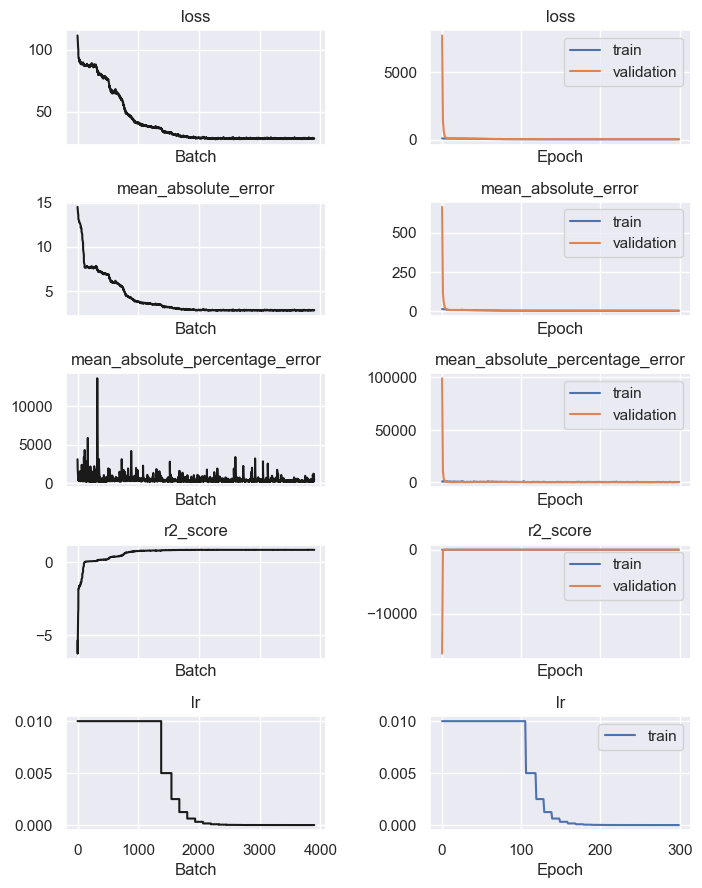

In [65]:
loadmodel = None
if train: 
    PlotHistory(loss_history, path=tagdir)
else:
    checkpoint_path = f"{tagdir}/training_20231102-154447/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    loadmodel = getmodel(tag=tag_)
    loadmodel.load_weights(checkpoint_path)
    print(f"Loaded model from checkpoint path: {checkpoint_path}")

In [66]:
#if not train:
#    model = loadmodel
target_reg_val_train   = model.predict(fit_inputs)
target_val_train = y_train
target_reg_val_test    = model.predict(fit_tests)
target_val_test  = y_test

404/404 [==============================] - 1s 3ms/step


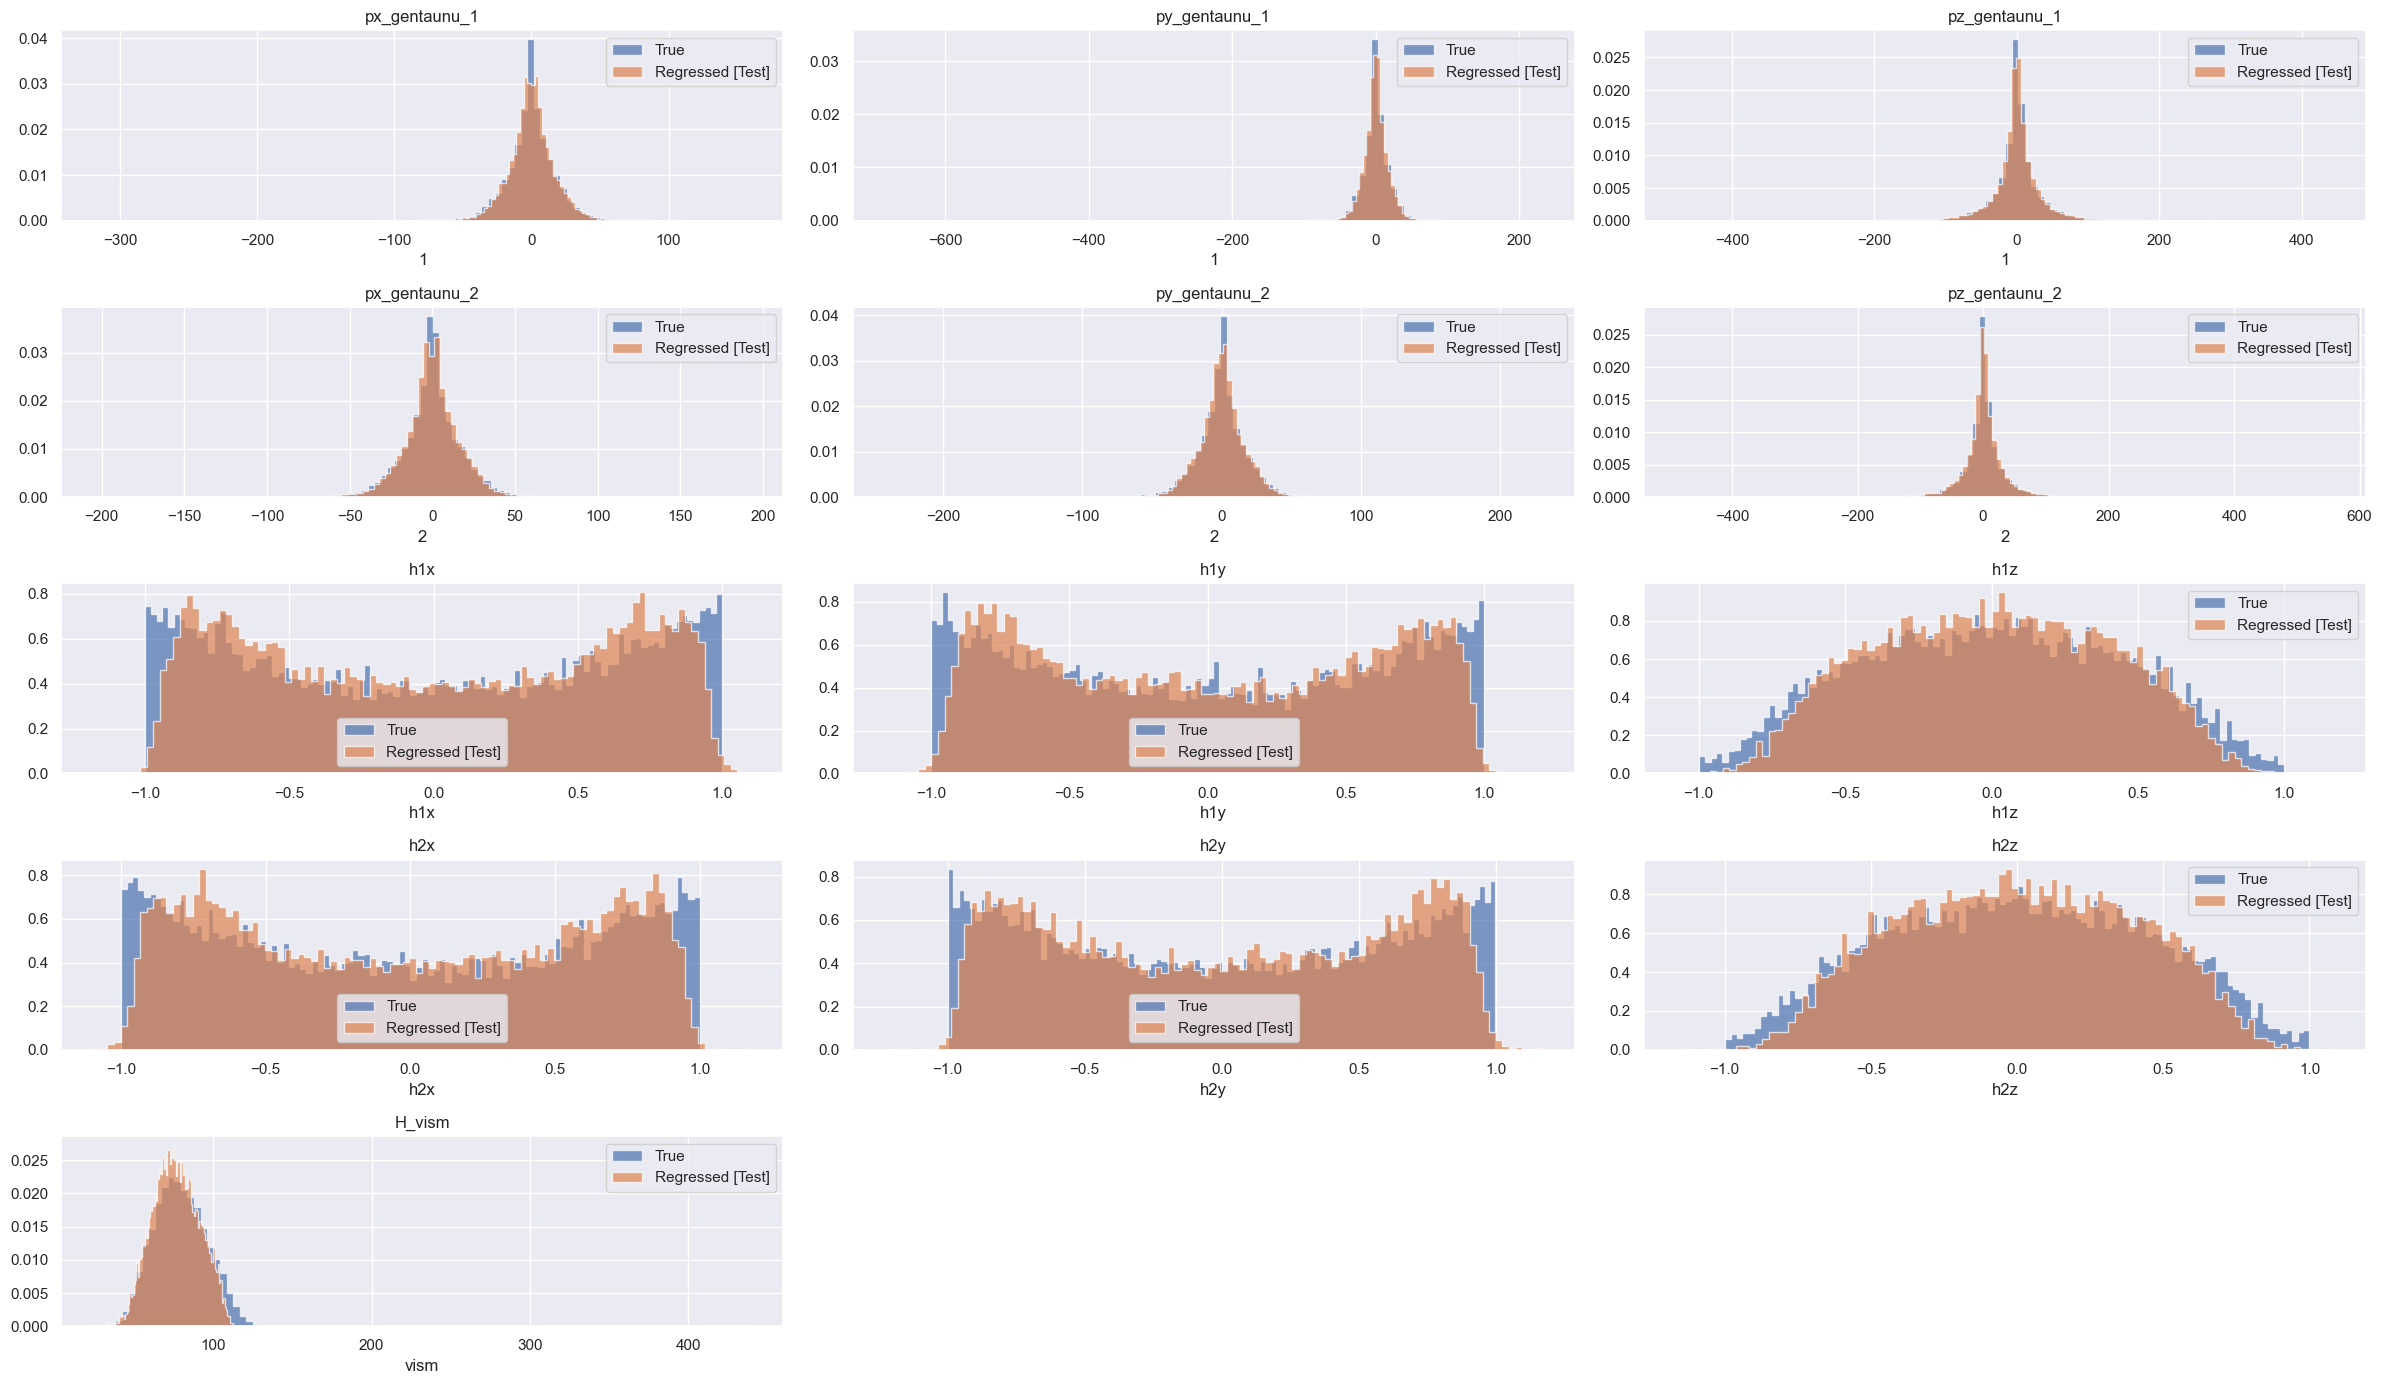

In [67]:
plt.figure(figsize=(24,14))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(5,3,idx)
    arr_true = target_val_test[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_test[:,(idx-1):idx].reshape(-1)

    #print(arr)
    minmax = [-50,50] if idx < 7 else [-1,1]
    ax.hist(arr_true, 100, histtype="stepfilled", alpha=0.7, label='True', log=False, density=True)
    ax.hist(arr_pred, 100, histtype="stepfilled", alpha=0.7, label='Regressed [Test]', log=False, density=True)
    ax.set_title(f"{key}")
    ax.set_xlabel(f"""{key.split('_')[-1]}""")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_test.png'), dpi=300)

In [68]:
"""
plt.figure(figsize=(20,16))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(4,3,idx)
    arr_true = target_val_test[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_test[:,(idx-1):idx].reshape(-1)

    #print(arr)
    minmax = [0,50] #if idx%4 == 0 else [0,6.5]
    ax.hist(np.abs(arr_true), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='True')
    ax.hist(np.abs(arr_pred), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='Regressed [Test]')
    ax.set_title(f"{key}")
    ax.set_xlabel(f"{key.split('_')[-1]}")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_test_abs.png'), dpi=300)
"""

'\nplt.figure(figsize=(20,16))\nfor idx, key in enumerate(targets):\n    idx=idx+1\n    ax = plt.subplot(4,3,idx)\n    arr_true = target_val_test[:,(idx-1):idx].reshape(-1)\n    arr_pred = target_reg_val_test[:,(idx-1):idx].reshape(-1)\n\n    #print(arr)\n    minmax = [0,50] #if idx%4 == 0 else [0,6.5]\n    ax.hist(np.abs(arr_true), 50, range=minmax, histtype="stepfilled", alpha=0.7, label=\'True\')\n    ax.hist(np.abs(arr_pred), 50, range=minmax, histtype="stepfilled", alpha=0.7, label=\'Regressed [Test]\')\n    ax.set_title(f"{key}")\n    ax.set_xlabel(f"{key.split(\'_\')[-1]}")\n    ax.legend()\nplt.tight_layout()\nplt.savefig(os.path.join(tagdir,\'output_test_abs.png\'), dpi=300)\n'

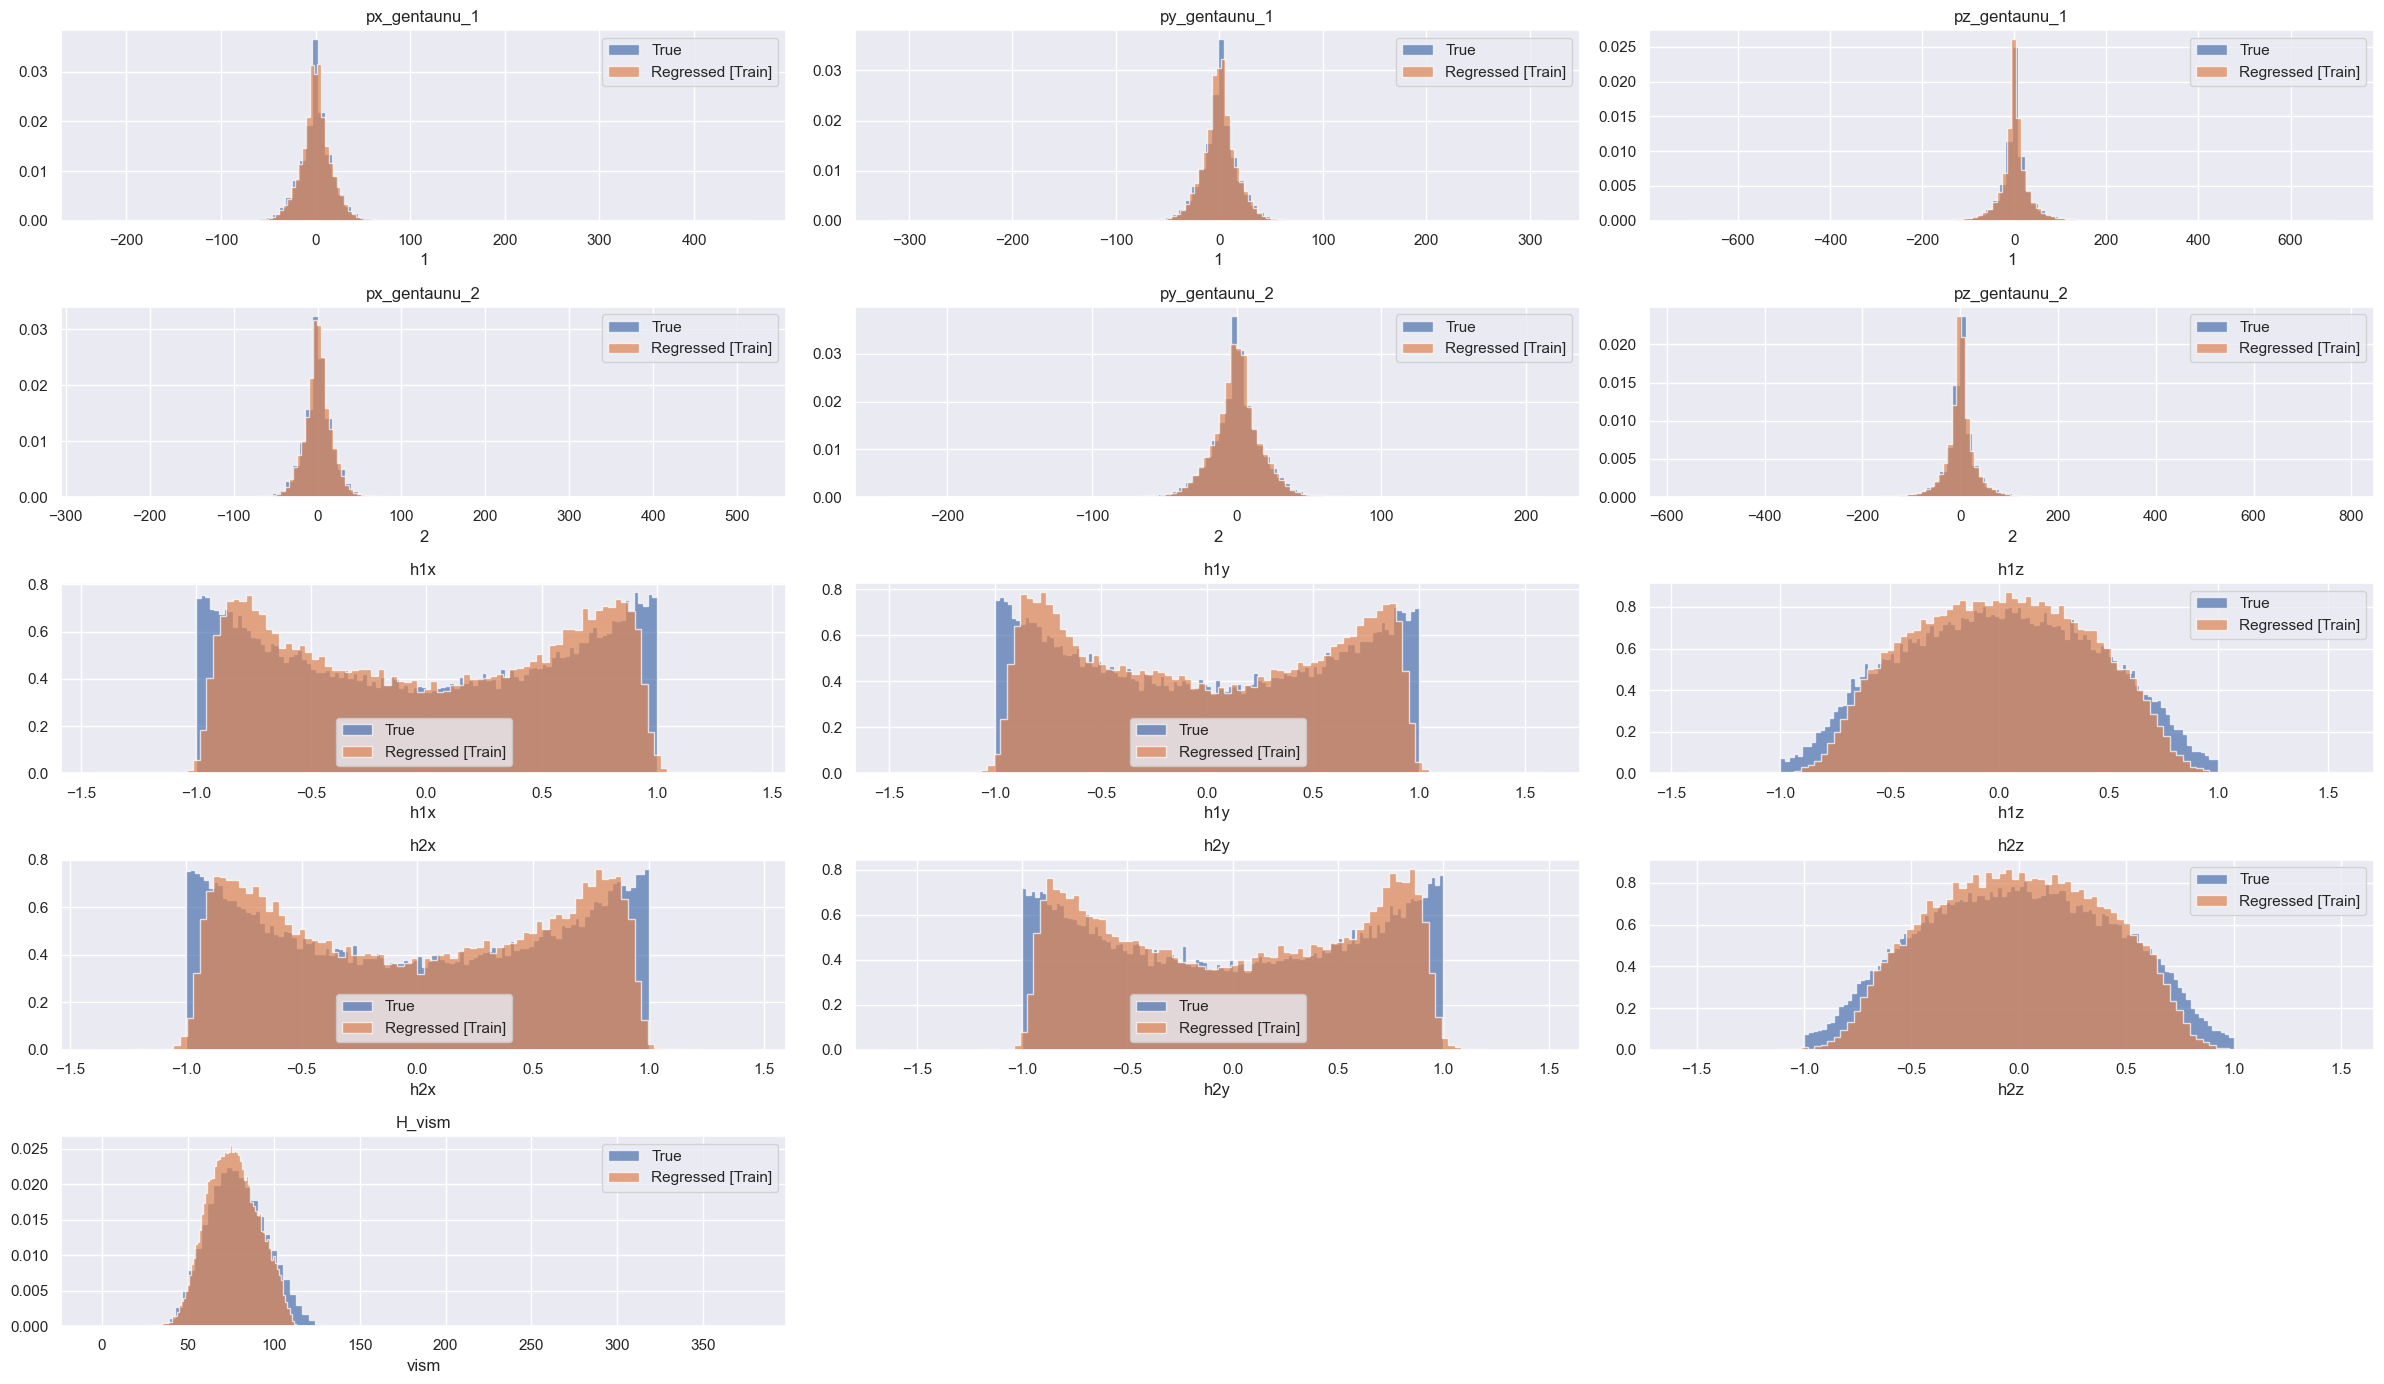

In [69]:
plt.figure(figsize=(24,14))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(5,3,idx)
    arr_true = target_val_train[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_train[:,(idx-1):idx].reshape(-1)

    #print(arr)
    #minmax = [-50,50] if np.min(arr_true) < 0 else [0,1]
    minmax = [-50,50] if idx < 7 else [-1,1]
    ax.hist(arr_true, 100, histtype="stepfilled", alpha=0.7, label='True', 
            log=False, density=True)
    ax.hist(arr_pred, 100, histtype="stepfilled", alpha=0.7, label='Regressed [Train]', 
            log=False, density=True)
    ax.set_title(f"{key}")
    ax.set_xlabel(f'''{key.split('_')[-1]}''')
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_train.png'), dpi=300)

In [70]:
"""
plt.figure(figsize=(20,16))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(2,3,idx)
    arr_true = target_val_train[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_train[:,(idx-1):idx].reshape(-1)

    #print(arr)
    minmax = [0,50] #if idx%4 == 0 else [0,50]
    ax.hist(np.abs(arr_true), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='True')
    ax.hist(np.abs(arr_pred), 50, range=minmax, histtype="stepfilled", alpha=0.7, label='Regressed [Train]')
    ax.set_title(f"{key}")
    ax.set_xlabel(f"{key.split('_')[-1]}")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_train_abs.png'), dpi=300)
"""

'\nplt.figure(figsize=(20,16))\nfor idx, key in enumerate(targets):\n    idx=idx+1\n    ax = plt.subplot(2,3,idx)\n    arr_true = target_val_train[:,(idx-1):idx].reshape(-1)\n    arr_pred = target_reg_val_train[:,(idx-1):idx].reshape(-1)\n\n    #print(arr)\n    minmax = [0,50] #if idx%4 == 0 else [0,50]\n    ax.hist(np.abs(arr_true), 50, range=minmax, histtype="stepfilled", alpha=0.7, label=\'True\')\n    ax.hist(np.abs(arr_pred), 50, range=minmax, histtype="stepfilled", alpha=0.7, label=\'Regressed [Train]\')\n    ax.set_title(f"{key}")\n    ax.set_xlabel(f"{key.split(\'_\')[-1]}")\n    ax.legend()\nplt.tight_layout()\nplt.savefig(os.path.join(tagdir,\'output_train_abs.png\'), dpi=300)\n'

In [71]:
true_nu1_p4 = vector.array({"px": target_val_test[:,:1].reshape(-1),
                            "py": target_val_test[:,1:2].reshape(-1),
                            "pz": target_val_test[:,2:3].reshape(-1),
                            #"E": target_val_test[:,3:4]})
                            "E": np.sqrt(target_val_test[:,:1]**2 + target_val_test[:,1:2]**2 + target_val_test[:,2:3]**2).reshape(-1)})
true_nu2_p4 = vector.array({"px": target_val_test[:,3:4].reshape(-1),
                            "py": target_val_test[:,4:5].reshape(-1),
                            "pz": target_val_test[:,5:6].reshape(-1),
                            #"E": target_val_test[:,7:8]})
                            "E": np.sqrt(target_val_test[:,3:4]**2 + target_val_test[:,4:5]**2 + target_val_test[:,5:6]**2).reshape(-1)})

In [72]:
true_nu1_p4.phi

array([-2.82812499,  0.94335937,  2.4140625 , ...,  2.85937501,
       -1.66406251, -0.0871582 ])

In [73]:
#rawmetphi_test = df2_met_raw_phi_test["met_phi_raw"].to_numpy().reshape(-1)

In [74]:
## add met phi
#true_nu1_p4 = vector.array({"pt": true_nu1_p4.pt,
#                            "eta": true_nu1_p4.eta,
#                            "phi": true_nu1_p4.phi + rawmetphi_test,
#                            "M": np.zeros_like(true_nu1_p4.pt)})
#true_nu2_p4 = vector.array({"pt": true_nu2_p4.pt,
#                            "eta": true_nu2_p4.eta,
#                            "phi": true_nu2_p4.phi + rawmetphi_test,
#                            "M": np.zeros_like(true_nu2_p4.pt)})

In [75]:
true_nu1_p4

MomentumNumpy4D([( -6.86698008,  -2.22596765,  17.32382011,  18.76766077),
                 (  0.15307438,   0.21107988,  -0.25839722,   0.36709073),
                 (-12.08913612,  10.76512718, -22.73618507,  27.91002127), ...,
                 ( -1.42940521,   0.41446587,  -2.8291378 ,   3.19671737),
                 ( -0.15606722,  -1.66849804,  -1.51199269,   2.25706991),
                 (124.52552032, -10.88098717, 202.09017944, 237.62458148)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

In [76]:
regr_nu1_p4 = vector.array({"px": target_reg_val_test[:,:1].reshape(-1),
                            "py": target_reg_val_test[:,1:2].reshape(-1),
                            "pz": target_reg_val_test[:,2:3].reshape(-1),
                            #"E": target_val_test[:,3:4]})
                            "E": np.sqrt(target_reg_val_test[:,:1]**2 + target_reg_val_test[:,1:2]**2 + target_reg_val_test[:,2:3]**2).reshape(-1)})
regr_nu2_p4 = vector.array({"px": target_reg_val_test[:,3:4].reshape(-1),
                            "py": target_reg_val_test[:,4:5].reshape(-1),
                            "pz": target_reg_val_test[:,5:6].reshape(-1),
                            #"E": target_val_test[:,7:8]})
                            "E": np.sqrt(target_reg_val_test[:,3:4]**2 + target_reg_val_test[:,4:5]**2 + target_reg_val_test[:,5:6]**2).reshape(-1)})

"""
regr_nu1_p4 = vector.array({"px": target_reg_val_test[:,:1],
                            "py": target_reg_val_test[:,1:2],
                            "pz": target_reg_val_test[:,2:3],
                            "E": target_reg_val_test[:,3:4]})
regr_nu2_p4 = vector.array({"px": target_reg_val_test[:,4:5],
                            "py": target_reg_val_test[:,5:6],
                            "pz": target_reg_val_test[:,6:7],
                            "E": target_reg_val_test[:,7:8]})
"""

'\nregr_nu1_p4 = vector.array({"px": target_reg_val_test[:,:1],\n                            "py": target_reg_val_test[:,1:2],\n                            "pz": target_reg_val_test[:,2:3],\n                            "E": target_reg_val_test[:,3:4]})\nregr_nu2_p4 = vector.array({"px": target_reg_val_test[:,4:5],\n                            "py": target_reg_val_test[:,5:6],\n                            "pz": target_reg_val_test[:,6:7],\n                            "E": target_reg_val_test[:,7:8]})\n'

In [77]:
## add met phi
#regr_nu1_p4 = vector.array({"pt": regr_nu1_p4.pt,
#                            "eta": regr_nu1_p4.eta,
#                            "phi": regr_nu1_p4.phi + rawmetphi_test,
#                            "M": np.zeros_like(regr_nu1_p4.pt)})
#regr_nu2_p4 = vector.array({"pt": regr_nu2_p4.pt,
#                            "eta": regr_nu2_p4.eta,
#                            "phi": regr_nu2_p4.phi + rawmetphi_test,
#                            "M": np.zeros_like(regr_nu2_p4.pt)})

In [78]:
true_nu1_p4, regr_nu1_p4

(MomentumNumpy4D([( -6.86698008,  -2.22596765,  17.32382011,  18.76766077),
                  (  0.15307438,   0.21107988,  -0.25839722,   0.36709073),
                  (-12.08913612,  10.76512718, -22.73618507,  27.91002127), ...,
                  ( -1.42940521,   0.41446587,  -2.8291378 ,   3.19671737),
                  ( -0.15606722,  -1.66849804,  -1.51199269,   2.25706991),
                  (124.52552032, -10.88098717, 202.09017944, 237.62458148)],
                 dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')]),
 MomentumNumpy4D([(-5.6360955e+00, -1.727656 ,  14.97508  ,  16.093582 ),
                  ( 4.9950848e+00,  4.4362397, -13.015486 ,  14.6299   ),
                  (-1.0477752e+01,  9.756734 , -20.540983 ,  25.038153 ), ...,
                  (-8.4166622e+00,  0.8996854, -14.792174 ,  17.04283  ),
                  ( 4.2100206e-02, -6.307642 ,  -4.4488916,   7.7188573),
                  ( 1.3856198e+02, 10.628043 , 237.53473  , 275.20016  )],
      

In [79]:
nu1_dict = {
    'nu1_pt_true': true_nu1_p4.pt,
    'nu1_pt_regr': regr_nu1_p4.pt,
    'nu1_eta_true': true_nu1_p4.eta,
    'nu1_eta_regr': regr_nu1_p4.eta,
    'nu1_phi_true': true_nu1_p4.phi,
    'nu1_phi_regr': regr_nu1_p4.phi,
    'nu1_p_true': true_nu1_p4.p,
    'nu1_p_regr': regr_nu1_p4.p,
}
nu2_dict = {
    'nu2_pt_true': true_nu2_p4.pt,
    'nu2_pt_regr': regr_nu2_p4.pt,
    'nu2_eta_true': true_nu2_p4.eta,
    'nu2_eta_regr': regr_nu2_p4.eta,
    'nu2_phi_true': true_nu2_p4.phi,
    'nu2_phi_regr': regr_nu2_p4.phi,
    'nu2_p_true': true_nu2_p4.p,
    'nu2_p_regr': regr_nu2_p4.p,
}
items = ['pt', 'eta', 'phi', 'p']

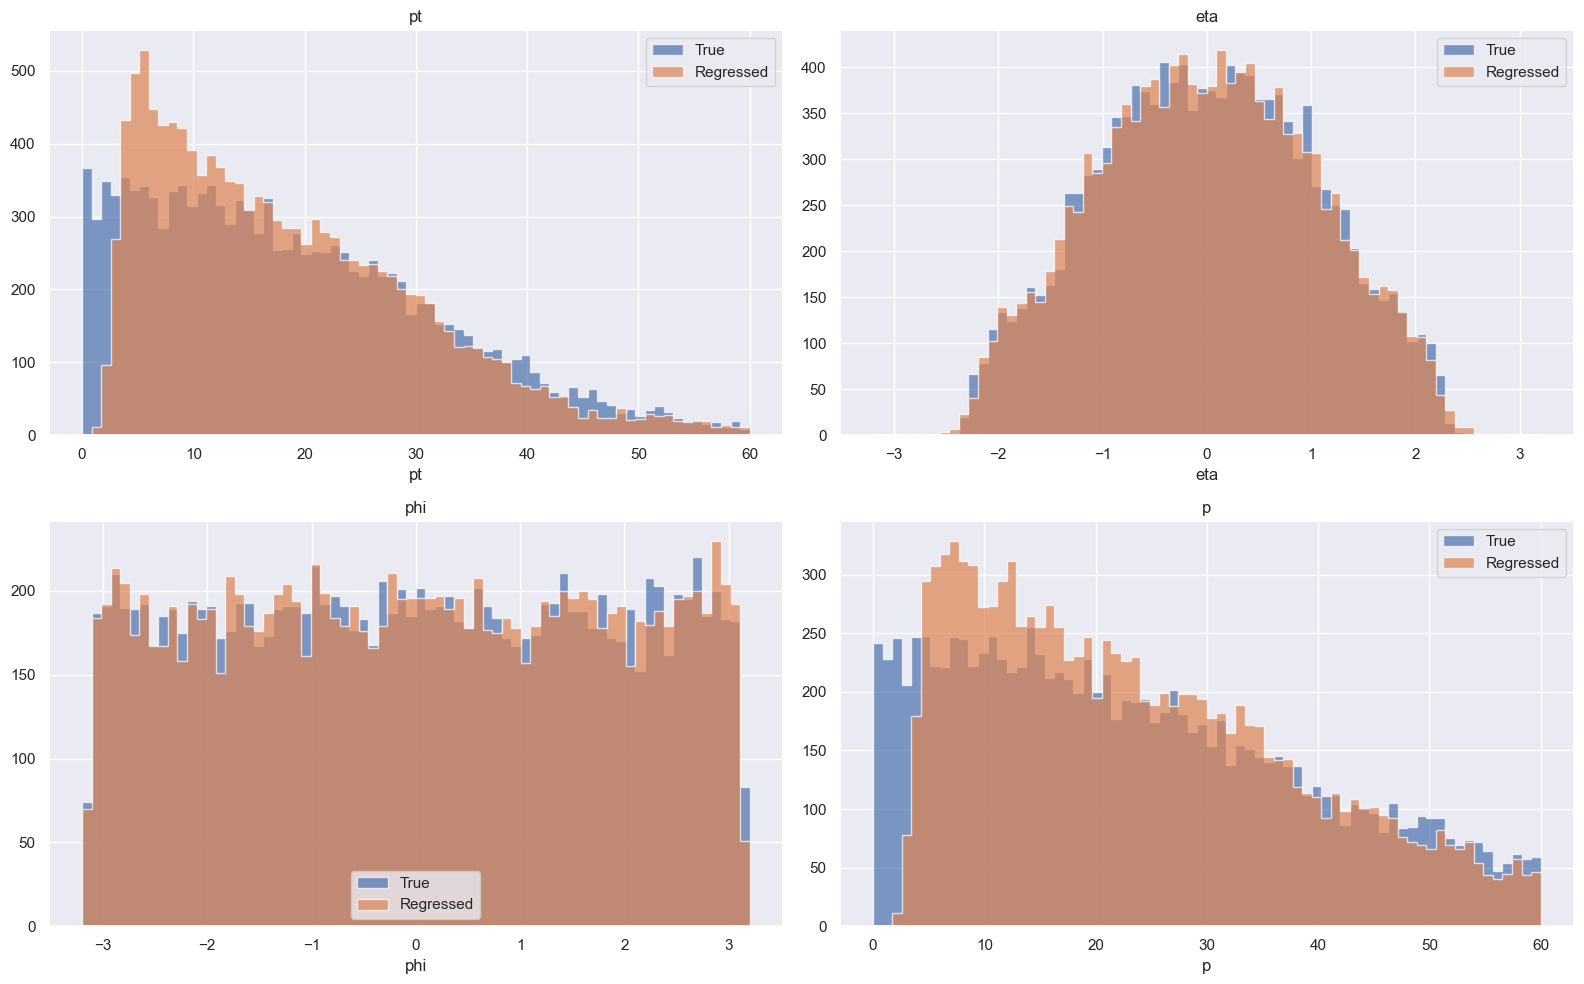

In [80]:
plt.figure(figsize=(16,10))
for idx, key in enumerate(items):
    idx=idx+1
    ax = plt.subplot(2,2,idx)
    arr_true = nu1_dict[f'nu1_{key}_true'].reshape(-1)
    arr_pred = nu1_dict[f'nu1_{key}_regr'].reshape(-1)

    #print(arr)
    minmax = [-3.2,3.2] if np.min(arr_true) < 0 else [0,60]
    ax.hist(arr_true, 70, range=minmax, histtype="stepfilled", alpha=0.7, label='True')
    ax.hist(arr_pred, 70, range=minmax, histtype="stepfilled", alpha=0.7, label='Regressed')
    ax.set_title(f"{key}")
    ax.set_xlabel(f"""{key.split('_')[-1]}""")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_nu_1.png'), dpi=300)

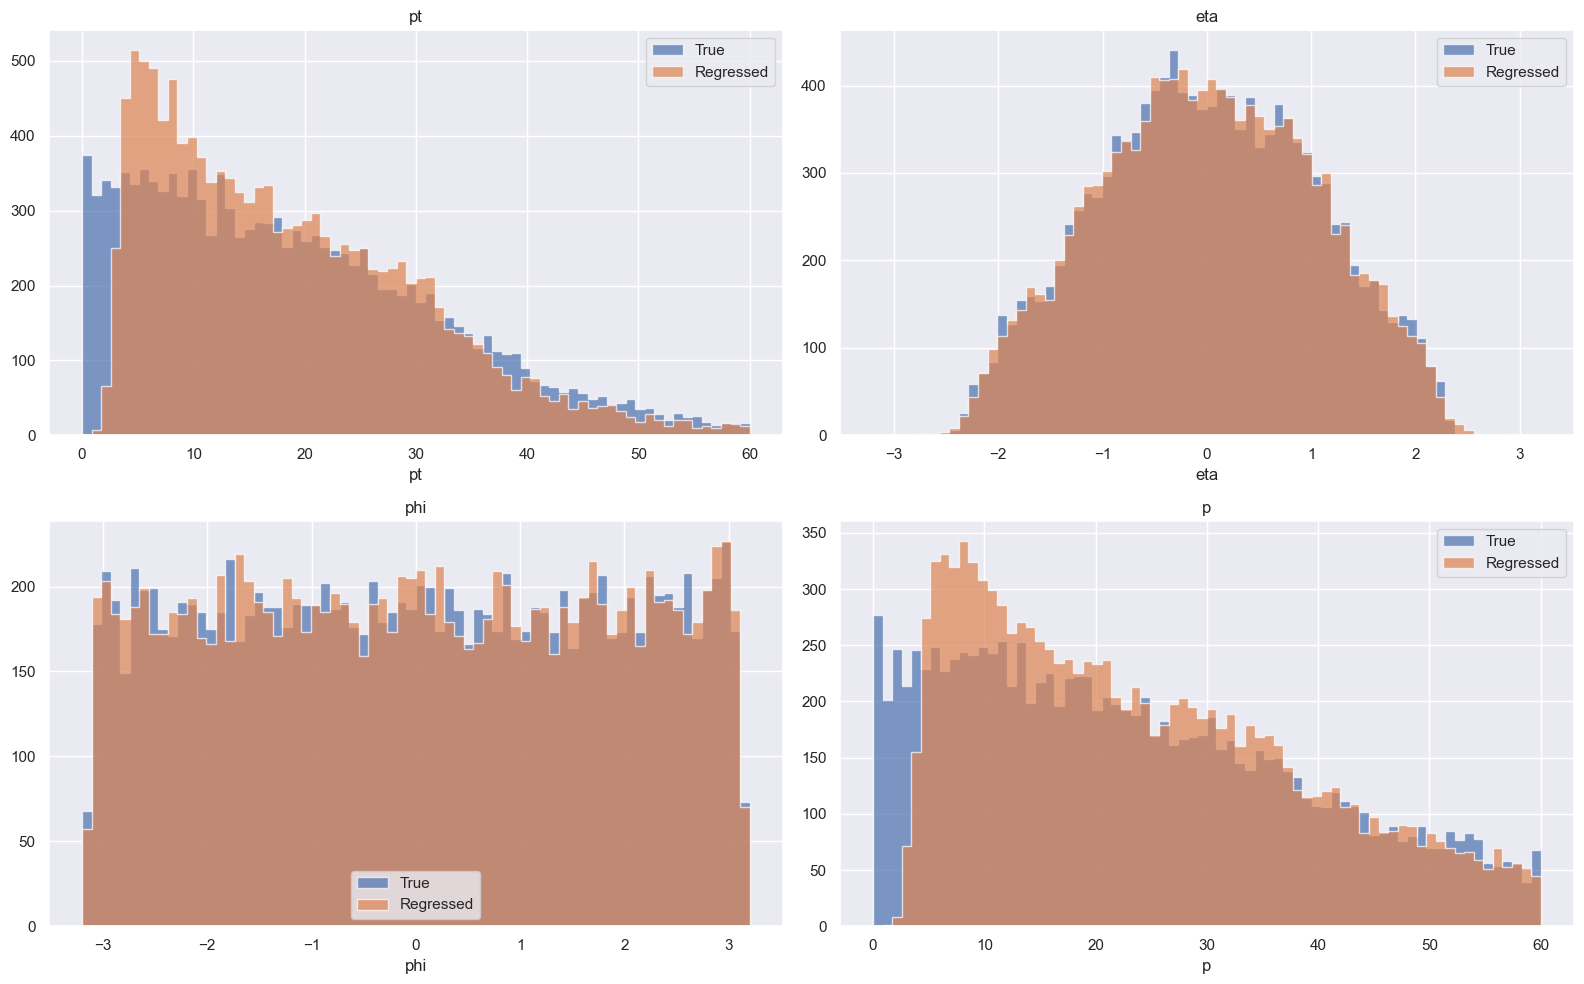

In [81]:
plt.figure(figsize=(16,10))
for idx, key in enumerate(items):
    idx=idx+1
    ax = plt.subplot(2,2,idx)
    arr_true = nu2_dict[f'nu2_{key}_true'].reshape(-1)
    arr_pred = nu2_dict[f'nu2_{key}_regr'].reshape(-1)

    #print(arr)
    minmax = [-3.2,3.2] if np.min(arr_true) < 0 else [0,60]
    ax.hist(arr_true, 70, range=minmax, histtype="stepfilled", alpha=0.7, label='True')
    ax.hist(arr_pred, 70, range=minmax, histtype="stepfilled", alpha=0.7, label='Regressed')
    ax.set_title(f"{key}")
    ax.set_xlabel(f"""{key.split('_')[-1]}""")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tagdir,'output_nu_2.png'), dpi=300)

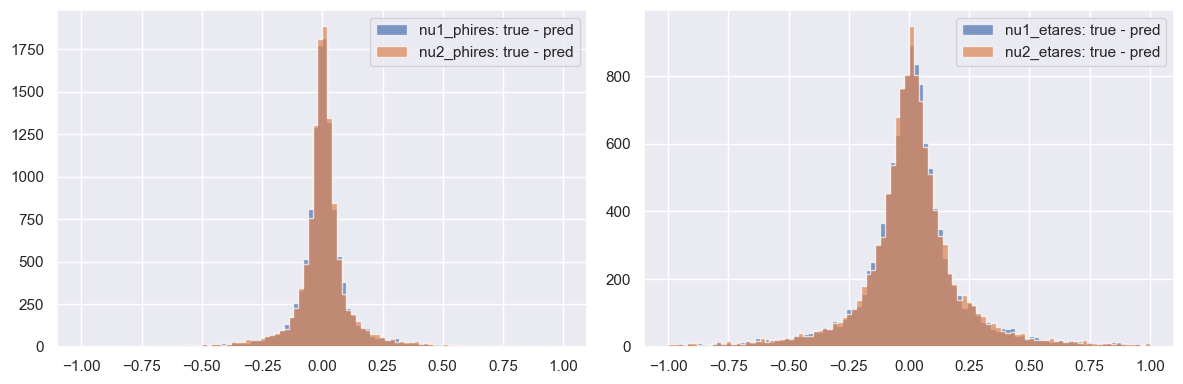

In [82]:
phitemp1 = (nu1_dict['nu1_phi_true'] - nu1_dict['nu1_phi_regr'])/nu1_dict['nu1_phi_true']
phitemp2 = (nu2_dict['nu2_phi_true'] - nu2_dict['nu2_phi_regr'])/nu2_dict['nu2_phi_true']

etatemp1 = (nu1_dict['nu1_eta_true'] - nu1_dict['nu1_eta_regr'])/nu1_dict['nu1_eta_true']
etatemp2 = (nu2_dict['nu2_eta_true'] - nu2_dict['nu2_eta_regr'])/nu2_dict['nu2_eta_true']

fig, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].hist(phitemp1, bins=100, range=[-1,1], histtype="stepfilled", alpha=0.7, log=False, label= "nu1_phires: true - pred")
ax[0].hist(phitemp2, bins=100, range=[-1,1], histtype="stepfilled", alpha=0.7, log=False, label= "nu2_phires: true - pred")
ax[0].legend()

ax[1].hist(etatemp1, bins=100, range=[-1,1], histtype="stepfilled", alpha=0.7, log=False, label= "nu1_etares: true - pred")
ax[1].hist(etatemp2, bins=100, range=[-1,1], histtype="stepfilled", alpha=0.7, log=False, label= "nu2_etares: true - pred")
ax[1].legend()

plt.tight_layout()
#plt.savefig(os.path.join(tagdir,"tau_nu_pt.png"), dpi=300)
#plt.show()
#plt.xlabel("nu1 (true_phi - pred_phi) / true_phi")
#plt.show()
plt.savefig(os.path.join(tagdir,'nu_eta_phi_res.png'), dpi=300)

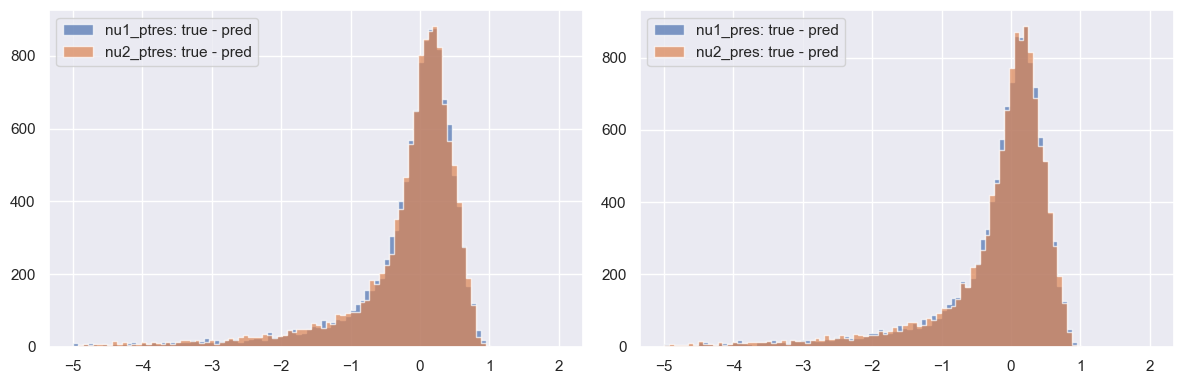

In [83]:
phitemp1 = (nu1_dict['nu1_pt_true'] - nu1_dict['nu1_pt_regr'])/nu1_dict['nu1_pt_true']
phitemp2 = (nu2_dict['nu2_pt_true'] - nu2_dict['nu2_pt_regr'])/nu2_dict['nu2_pt_true']

etatemp1 = (nu1_dict['nu1_p_true'] - nu1_dict['nu1_p_regr'])/nu1_dict['nu1_p_true']
etatemp2 = (nu2_dict['nu2_p_true'] - nu2_dict['nu2_p_regr'])/nu2_dict['nu2_p_true']

fig, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].hist(phitemp1, bins=100, range=[-5,2], histtype="stepfilled", alpha=0.7, log=False, label= "nu1_ptres: true - pred")
ax[0].hist(phitemp2, bins=100, range=[-5,2], histtype="stepfilled", alpha=0.7, log=False, label= "nu2_ptres: true - pred")
ax[0].legend()

ax[1].hist(etatemp1, bins=100, range=[-5,2], histtype="stepfilled", alpha=0.7, log=False, label= "nu1_pres: true - pred")
ax[1].hist(etatemp2, bins=100, range=[-5,2], histtype="stepfilled", alpha=0.7, log=False, label= "nu2_pres: true - pred")
ax[1].legend()

plt.tight_layout()
#plt.savefig(os.path.join(tagdir,"tau_nu_pt.png"), dpi=300)
#plt.show()
#plt.xlabel("nu1 (true_phi - pred_phi) / true_phi")
#plt.show()
plt.savefig(os.path.join(tagdir,'nu_pt_p_res.png'), dpi=300)

In [84]:
#vis_tau_1_p4 = getp4(df_test_x, vars=["tau_1_pt", "tau_1_eta", "tau_1_phi", "tau_1_mass"], LVtype="ptetaphim")


vis_tau_1_p4 = vector.array({"pt": df_test_x["pt_tau_1"].to_numpy(),
                             "eta": df_test_x["eta_tau_1"].to_numpy(),
                             "phi": df_test_x["phi_tau_1"].to_numpy(),# + df2_met_raw_phi_test["met_phi_raw"].to_numpy(),
                             "M": df_test_x["mass_tau_1"].to_numpy()})
vis_tau_2_p4 = vector.array({"pt": df_test_x["pt_tau_2"].to_numpy(),
                             "eta": df_test_x["eta_tau_2"].to_numpy(),
                             "phi": df_test_x["phi_tau_2"].to_numpy(),# + df2_met_raw_phi_test["met_phi_raw"].to_numpy(),
                             "M": df_test_x["mass_tau_2"].to_numpy()})

In [85]:
vis_tau_2_p4

MomentumNumpy4D([(36.54556656, -0.14376831,  0.06318665, 0.65478516),
                 (27.37777138, -2.25976562,  0.29162598, 0.13952637),
                 (29.564888  , -0.85449219, -1.32958984, 0.13952637), ...,
                 (28.73810577,  0.0051012 , -0.29577637, 0.45068359),
                 (23.21935463,  1.23144531, -1.27294922, 0.64648438),
                 (24.96731567, -1.59643555,  2.22314453, 0.71582031)],
                dtype=[('rho', '<f8'), ('phi', '<f8'), ('eta', '<f8'), ('tau', '<f8')])

In [86]:
vis_Z_p4 = vis_tau_1_p4 + vis_tau_2_p4
m = vis_Z_p4.M

In [87]:
m

array([103.23874096,  92.16371494,  74.08759761, ...,  76.06830944,
        70.41101947,  64.27432886])

In [88]:
np.mean(m)

78.97086301775609

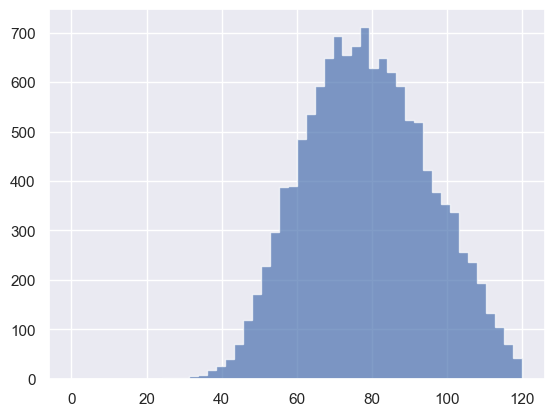

In [89]:
plt.hist(vis_Z_p4.M, range=[0,120], bins=50, histtype="stepfilled", alpha=0.7)
plt.show()

In [90]:
"""
true_full_tau_1_p4 = vis_tau_1_p4 + true_nu1_p4
true_full_tau_2_p4 = vis_tau_2_p4 + true_nu2_p4
true_Z_p4 = true_full_tau_1_p4 + true_full_tau_2_p4

regr_full_tau_1_p4 = vis_tau_1_p4 + regr_nu1_p4
regr_full_tau_2_p4 = vis_tau_2_p4 + regr_nu2_p4
regr_Z_p4 = regr_full_tau_1_p4 + regr_full_tau_2_p4

plt.hist(true_Z_p4.M, range=[0,120], bins=50, histtype="stepfilled", alpha=0.7)
plt.hist(regr_Z_p4.M, range=[0,120], bins=50, histtype="stepfilled", alpha=0.7)

plt.show()
"""

'\ntrue_full_tau_1_p4 = vis_tau_1_p4 + true_nu1_p4\ntrue_full_tau_2_p4 = vis_tau_2_p4 + true_nu2_p4\ntrue_Z_p4 = true_full_tau_1_p4 + true_full_tau_2_p4\n\nregr_full_tau_1_p4 = vis_tau_1_p4 + regr_nu1_p4\nregr_full_tau_2_p4 = vis_tau_2_p4 + regr_nu2_p4\nregr_Z_p4 = regr_full_tau_1_p4 + regr_full_tau_2_p4\n\nplt.hist(true_Z_p4.M, range=[0,120], bins=50, histtype="stepfilled", alpha=0.7)\nplt.hist(regr_Z_p4.M, range=[0,120], bins=50, histtype="stepfilled", alpha=0.7)\n\nplt.show()\n'

In [91]:
true_nu1_p4.pt

array([  7.21874971,   0.26074218,  16.18750059, ...,   1.4882813 ,
         1.67578122, 125.00000438])

In [92]:
true_tau1p4 = vis_tau_1_p4 + true_nu1_p4
true_tau2p4 = vis_tau_2_p4 + true_nu2_p4
true_mass = (true_tau1p4 + true_tau2p4).M
true_mass, np.mean(true_mass)

(array([113.6568577 , 127.36119848, 123.46033312, ..., 117.04267755,
         99.47258721, 118.2234555 ]),
 119.20603473632943)

In [93]:
regr_tau1p4 = vis_tau_1_p4 + regr_nu1_p4
regr_tau2p4 = vis_tau_2_p4 + regr_nu2_p4
regr_mass = (regr_tau1p4 + regr_tau2p4).M
regr_mass, np.mean(regr_mass)

(array([125.86547839, 116.45106796, 115.81192531, ..., 108.40075069,
        119.66550794, 130.87241524]),
 118.316978452466)

In [94]:
vis_mass = (vis_tau_1_p4 + vis_tau_2_p4).mass

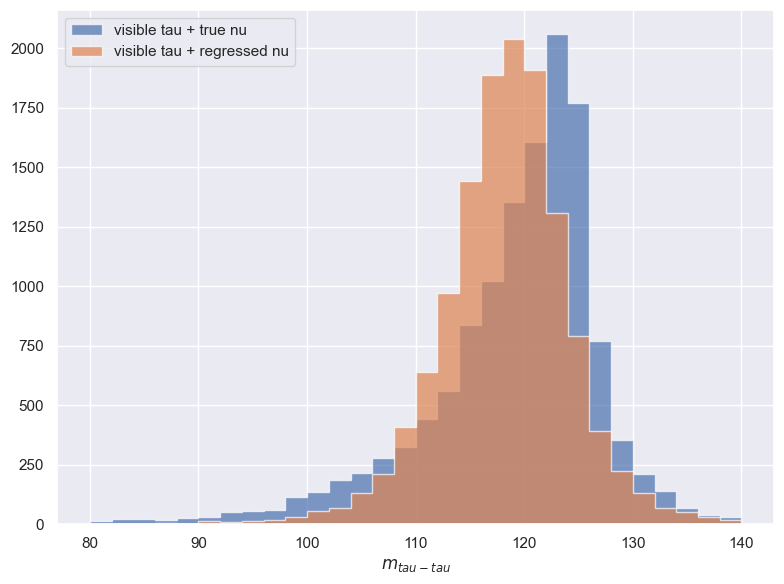

In [95]:
plt.figure(figsize=(8,6))

plt.hist(true_mass, range=[80,140], bins=30, histtype="stepfilled", alpha=0.7, label="visible tau + true nu")
plt.hist(regr_mass, range=[80,140], bins=30, histtype="stepfilled", alpha=0.7, label="visible tau + regressed nu")
plt.xlabel("$m_{tau-tau}$")
plt.legend()


plt.tight_layout()
plt.savefig(os.path.join(tagdir,'mass_tau_tau.png'), dpi=300)